In [ ]:
# ============================================
# Macro Project: CPI, Fed Funds, Markets, Stimulus
# All-in-one Jupyter script
# ============================================

# ---- Imports
import os, io, json, textwrap, math, datetime as dt
from dataclasses import dataclass
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt

# ---- Config / Output folders
OUT_DIR = "out"                 # change if you like
BRONZE = os.path.join(OUT_DIR, "bronze")
SILVER = os.path.join(OUT_DIR, "silver")
GOLD   = os.path.join(OUT_DIR, "gold")
for d in [OUT_DIR, BRONZE, SILVER, GOLD]:
    os.makedirs(d, exist_ok=True)

# ---- Helpers
def month_end(d):
    d = pd.Timestamp(d)
    return (d + pd.offsets.MonthEnd(0)).normalize()

def to_month_index(s: pd.Series) -> pd.Series:
    return s.map(month_end)

def yoy(series: pd.Series, periods=12) -> pd.Series:
    return series.div(series.shift(periods)) - 1

def pct_change(series: pd.Series, periods=1) -> pd.Series:
    return series.pct_change(periods)

def save(df: pd.DataFrame, base: str):
    """Save both Parquet and CSV."""
    pqt = f"{base}.parquet"
    csv = f"{base}.csv"
    df.to_parquet(pqt, index=True)
    df.to_csv(csv, index=True)
    print(f"Saved: {pqt} and {csv}")

# ---- FRED fetcher
FRED_API_KEY = os.getenv("FRED_API_KEY", "").strip()
FRED_BASE = "https://api.stlouisfed.org/fred/series/observations"

def fetch_fred_series(series_id: str,
                      start="1947-01-01",
                      end=None,
                      frequency="m") -> pd.DataFrame:
    """
    Returns a monthly DataFrame with columns:
      date (Timestamp, month-end), value (float)
    """
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "frequency": frequency
    }
    if start:
        params["observation_start"] = start
    if end:
        params["observation_end"] = end

    r = requests.get(FRED_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json().get("observations", [])
    df = pd.DataFrame(data)
    if df.empty:
        raise ValueError(f"No data from FRED for {series_id}")
    df["date"] = pd.to_datetime(df["date"]).map(month_end)
    # FRED sometimes has "." for missing values
    df["value"] = pd.to_numeric(df["value"].replace(".", np.nan), errors="coerce")
    df = df[["date", "value"]].dropna().sort_values("date").reset_index(drop=True)
    return df

# ---- Yahoo Finance helper (S&P 500)
def fetch_sp500_monthly(start="1950-01-01", end=None) -> pd.DataFrame:
    """
    Pull ^GSPC from Yahoo Finance, monthly.
    Returns columns: date, close, ret_1m
    """
    if end is None:
        end = dt.date.today().isoformat()
    sp = yf.download("^GSPC", start=start, end=end, interval="1mo", auto_adjust=True, progress=False)
    sp = sp.rename_axis("date").reset_index()
    sp["date"] = sp["date"].map(month_end)
    sp = sp[["date", "Close"]].rename(columns={"Close": "close"})
    sp["ret_1m"] = sp["close"].pct_change()
    return sp.dropna().reset_index(drop=True)

# =========================
# 1) BRONZE: pull raw data
# =========================

print("Fetching CPI (CPIAUCSL) …")
bronze_cpi = fetch_fred_series("CPIAUCSL", start="1950-01-01")
save(bronze_cpi, os.path.join(BRONZE, "fred_cpi_CPIAUCSL"))

print("Fetching Fed Funds (FEDFUNDS) …")
bronze_ffr = fetch_fred_series("FEDFUNDS", start="1954-07-01")
save(bronze_ffr, os.path.join(BRONZE, "fred_fedfunds_FEDFUNDS"))

print("Fetching NBER Recession indicator (USREC) …")
bronze_usrec = fetch_fred_series("USREC", start="1950-01-01")
bronze_usrec["value"] = bronze_usrec["value"].astype(int)
save(bronze_usrec, os.path.join(BRONZE, "fred_usrec_USREC"))

print("Fetching S&P 500 monthly (^GSPC) …")
bronze_spx = fetch_sp500_monthly(start="1950-01-01")
save(bronze_spx, os.path.join(BRONZE, "yahoo_sp500_GSPC"))

# ======================================
# 2) SILVER: tidy, typed, aligned monthly
# ======================================

silver_cpi = bronze_cpi.rename(columns={"value": "cpi_index"}).set_index("date")
silver_ffr = bronze_ffr.rename(columns={"value": "ffr"}).set_index("date")
silver_usrec = bronze_usrec.rename(columns={"value": "recession"}).set_index("date")
silver_spx = bronze_spx.set_index("date")

# Make sure all are month-end aligned; join later on full index
common_index = pd.date_range(
    start=min(df.index.min() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    end=max(df.index.max() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    freq="M"
)

silver_cpi = silver_cpi.reindex(common_index).interpolate()
silver_ffr = silver_ffr.reindex(common_index).interpolate()
silver_usrec = silver_usrec.reindex(common_index).fillna(method="ffill").fillna(0).astype(int)
silver_spx = silver_spx.reindex(common_index).interpolate()
silver_spx["ret_3m"] = (silver_spx["close"] / silver_spx["close"].shift(3) - 1)

save(silver_cpi.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "cpi_monthly"))
save(silver_ffr.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "fedfunds_monthly"))
save(silver_spx.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "sp500_monthly"))
save(silver_usrec.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "usrec_monthly"))

# ======================================
# 3) GOLD tables & analysis-friendly sets
# ======================================

# ---- GOLD (A): CPI vs Fed Funds (YoY, ΔFFR)
gold_a = pd.concat(
    [
        silver_cpi,
        silver_ffr,
        silver_usrec
    ],
    axis=1
).dropna(subset=["cpi_index", "ffr"])

gold_a["cpi_yoy"] = yoy(gold_a["cpi_index"])
gold_a["dcpi_yoy"] = gold_a["cpi_yoy"].diff()
gold_a["d_ffr"] = gold_a["ffr"].diff()
gold_a = gold_a.join(silver_spx[["close", "ret_1m", "ret_3m"]], how="left")

save(gold_a.reset_index().rename(columns={"index": "date"}), os.path.join(GOLD, "cpi_vs_fedfunds_monthly"))

# ---- Identify rate-hike cycles & lag to CPI deceleration
def tag_hiking_cycles(ffr: pd.Series, min_consecutive=2, rise_threshold=0.0):
    """
    Tags hiking 'cycles': sequences where d_ffr > rise_threshold for >= min_consecutive months.
    Returns a DataFrame with columns: cycle_id (int or NaN), is_hike_month (bool)
    """
    d = ffr.diff()
    up = (d > rise_threshold).astype(int)
    # group consecutive ups
    grp = (up.ne(up.shift()).cumsum()) * up
    sizes = up.groupby(grp).transform("size")
    cycle_id = grp.where((up == 1) & (sizes >= min_consecutive))
    return pd.DataFrame({"cycle_id": cycle_id, "is_hike_month": up.astype(bool)})

hike_tags = tag_hiking_cycles(gold_a["ffr"])
gold_a = gold_a.join(hike_tags)

def months_to_cpi_deceleration(df, window=6):
    """
    For each hiking cycle, compute months from the cycle start to the first sustained
    deceleration in CPI YoY (negative avg dcpi_yoy over a 'window' months).
    """
    results = []
    for cid in sorted(df["cycle_id"].dropna().unique()):
        block = df[df["cycle_id"] == cid].copy()
        start_date = block.index.min()
        # look forward up to 24 months from cycle start
        fwd = df.loc[start_date:].head(36).copy()
        fwd["dcpi_yoy_ma"] = fwd["dcpi_yoy"].rolling(window).mean()
        hit = fwd.index[fwd["dcpi_yoy_ma"] < 0]
        if len(hit) > 0:
            lag = (hit[0].to_period("M") - start_date.to_period("M")).n
            results.append({"cycle_id": int(cid), "start": start_date, "lag_months_to_decel": lag})
    return pd.DataFrame(results)

lags_df = months_to_cpi_deceleration(gold_a)
save(lags_df, os.path.join(GOLD, "headline_metrics_rate_hike_lags"))

print("\nRate-hike effectiveness: avg months to CPI deceleration:")
if not lags_df.empty:
    print(round(lags_df["lag_months_to_decel"].mean(), 2), "months (avg)")
else:
    print("No cycles detected by the simple rule—tweak thresholds if needed.")

# ---- GOLD (B): CPI lead/lag vs market
def cross_corr_at_lags(x: pd.Series, y: pd.Series, lags=range(-12, 13)):
    """
    Returns DataFrame with lag and correlation.
    By convention, positive lag means x LEADS y by 'lag' months (x shifted forward).
    """
    out = []
    for L in lags:
        if L >= 0:
            corr = x.shift(L).corr(y)
        else:
            corr = x.corr(y.shift(-L))
        out.append({"lag": L, "corr": corr})
    return pd.DataFrame(out)

leadlag_df = cross_corr_at_lags(gold_a["cpi_yoy"], gold_a["ret_1m"], lags=range(-18, 19))
save(leadlag_df, os.path.join(GOLD, "cpi_leadlag_sp500_corr"))

# ---- GOLD (C): Stimulus Event Study (CPI indexed to 100 at t0)
# You can edit this list or load from CSV.
stimulus_events = pd.DataFrame([
    # program, event_date, notes
    ("2001 Tax Rebates",  "2001-07-01", "EGTRRA rebates"),
    ("ARRA 2009",         "2009-02-01", "Post-GFC stimulus"),
    ("COVID CARES 2020",  "2020-03-01", "Initial pandemic stimulus"),
    ("American Rescue 21","2021-03-01", "ARP Act")
], columns=["program","event_date","notes"])
stimulus_events["event_date"] = pd.to_datetime(stimulus_events["event_date"]).map(month_end)

# Build event windows t=-6..+12
cpi_df = silver_cpi.copy()
cpi_df["date"] = cpi_df.index
evt_list = []
for _, row in stimulus_events.iterrows():
    prog, t0, notes = row["program"], row["event_date"], row["notes"]
    window = pd.date_range(t0 - pd.offsets.MonthEnd(6), t0 + pd.offsets.MonthEnd(12), freq="M")
    w = cpi_df.reindex(window)[["cpi_index"]].copy()
    w["program"] = prog
    w["event_date"] = t0
    w["t"] = (w.index.to_period("M") - t0.to_period("M")).astype(int)
    # index CPI to 100 at t0
    cpi_t0 = w.loc[w["t"] == 0, "cpi_index"].iloc[0] if (w["t"] == 0).any() else np.nan
    w["cpi_indexed"] = 100 * w["cpi_index"] / cpi_t0
    evt_list.append(w.reset_index().rename(columns={"index": "date"}))

event_by_event = pd.concat(evt_list, ignore_index=True)
event_by_program = (event_by_event.groupby(["program","t"])
                    .agg(avg_cpi_indexed=("cpi_indexed","mean"))
                    .reset_index())

save(event_by_event,  os.path.join(GOLD, "stimulus_event_study_by_event"))
save(event_by_program, os.path.join(GOLD, "stimulus_event_study_by_program"))

# ======================================
# 4) Quick visuals (optional)
# ======================================

plt.figure(figsize=(11,5))
plt.plot(gold_a.index, gold_a["cpi_yoy"], label="CPI YoY")
plt.plot(gold_a.index, gold_a["ffr"]/100.0, label="Fed Funds (÷100 for scale)")
# recession shading
rec = gold_a["recession"].fillna(0)
in_rec = (rec.shift(1, fill_value=0) == 0) & (rec == 1)
out_rec = (rec.shift(1, fill_value=0) == 1) & (rec == 0)
starts = list(gold_a.index[in_rec])
ends   = list(gold_a.index[out_rec])
if len(ends) < len(starts):
    ends.append(gold_a.index[-1])
for s, e in zip(starts, ends):
    plt.axvspan(s, e, alpha=0.15)
plt.title("CPI YoY vs Fed Funds (with recessions shaded)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.bar(leadlag_df["lag"], leadlag_df["corr"])
plt.title("Correlation of CPI YoY vs. S&P 1m returns across lags\n(+lag = CPI leads market)")
plt.xlabel("Lag (months)")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
avg = event_by_program.pivot(index="t", columns="program", values="avg_cpi_indexed")
plt.plot(avg.index, avg)
plt.axvline(0, linestyle="--")
plt.title("Stimulus Event Study: CPI indexed to 100 at t0")
plt.xlabel("Months from event (t)")
plt.ylabel("Avg CPI (t0=100)")
plt.tight_layout()
plt.show()

# ======================================
# 5) Final: print headline metrics
# ======================================

print("\n=== Headline Metrics ===")
if not lags_df.empty:
    print(f"Avg months from hike-cycle start to CPI deceleration: {lags_df['lag_months_to_decel'].mean():.2f}")
else:
    print("No hiking cycles detected by the simple rule.")

best = leadlag_df.iloc[leadlag_df['corr'].abs().argmax()]
print(f"Lead/Lag with equities: max |corr|={best['corr']:.3f} at lag={int(best['lag'])} months "
      f"({'CPI leads' if best['lag']>0 else ('CPI lags' if best['lag']<0 else 'same month')}).")

print("Event study programs:", ", ".join(sorted(stimulus_events['program'].unique())))


In [4]:
# ============================================
# Macro Project: CPI, Fed Funds, Markets, Stimulus
# All-in-one Jupyter script
# ============================================

# ---- Imports
import os, io, json, textwrap, math, datetime as dt
from dataclasses import dataclass
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt

# ---- Config / Output folders
OUT_DIR = r"C:\Users\Brazi\OneDrive\Project"
BRONZE = os.path.join(OUT_DIR, "bronze")
SILVER = os.path.join(OUT_DIR, "silver")
GOLD   = os.path.join(OUT_DIR, "gold")
for d in [OUT_DIR, BRONZE, SILVER, GOLD]:
    os.makedirs(d, exist_ok=True)

# ---- Helpers
def month_end(d):
    d = pd.Timestamp(d)
    return (d + pd.offsets.MonthEnd(0)).normalize()

def to_month_index(s: pd.Series) -> pd.Series:
    return s.map(month_end)

def yoy(series: pd.Series, periods=12) -> pd.Series:
    return series.div(series.shift(periods)) - 1

def pct_change(series: pd.Series, periods=1) -> pd.Series:
    return series.pct_change(periods)

def save(df: pd.DataFrame, base: str):
    """Save both Parquet and CSV."""
    pqt = f"{base}.parquet"
    csv = f"{base}.csv"
    df.to_parquet(pqt, index=True)
    df.to_csv(csv, index=True)
    print(f"Saved: {pqt} and {csv}")

# ---- FRED fetcher
FRED_API_KEY = os.getenv("FRED_API_KEY", "").strip()
FRED_BASE = "https://api.stlouisfed.org/fred/series/observations"

def fetch_fred_series(series_id: str,
                      start="1947-01-01",
                      end=None,
                      frequency="m") -> pd.DataFrame:
    """
    Returns a monthly DataFrame with columns:
      date (Timestamp, month-end), value (float)
    """
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "frequency": frequency
    }
    if start:
        params["observation_start"] = start
    if end:
        params["observation_end"] = end

    r = requests.get(FRED_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json().get("observations", [])
    df = pd.DataFrame(data)
    if df.empty:
        raise ValueError(f"No data from FRED for {series_id}")
    df["date"] = pd.to_datetime(df["date"]).map(month_end)
    # FRED sometimes has "." for missing values
    df["value"] = pd.to_numeric(df["value"].replace(".", np.nan), errors="coerce")
    df = df[["date", "value"]].dropna().sort_values("date").reset_index(drop=True)
    return df

# ---- Yahoo Finance helper (S&P 500)
def fetch_sp500_monthly(start="1950-01-01", end=None) -> pd.DataFrame:
    """
    Pull ^GSPC from Yahoo Finance, monthly.
    Returns columns: date, close, ret_1m
    """
    if end is None:
        end = dt.date.today().isoformat()
    sp = yf.download("^GSPC", start=start, end=end, interval="1mo", auto_adjust=True, progress=False)
    sp = sp.rename_axis("date").reset_index()
    sp["date"] = sp["date"].map(month_end)
    sp = sp[["date", "Close"]].rename(columns={"Close": "close"})
    sp["ret_1m"] = sp["close"].pct_change()
    return sp.dropna().reset_index(drop=True)

# =========================
# 1) BRONZE: pull raw data
# =========================

print("Fetching CPI (CPIAUCSL) …")
bronze_cpi = fetch_fred_series("CPIAUCSL", start="1950-01-01")
save(bronze_cpi, os.path.join(BRONZE, "fred_cpi_CPIAUCSL"))

print("Fetching Fed Funds (FEDFUNDS) …")
bronze_ffr = fetch_fred_series("FEDFUNDS", start="1954-07-01")
save(bronze_ffr, os.path.join(BRONZE, "fred_fedfunds_FEDFUNDS"))

print("Fetching NBER Recession indicator (USREC) …")
bronze_usrec = fetch_fred_series("USREC", start="1950-01-01")
bronze_usrec["value"] = bronze_usrec["value"].astype(int)
save(bronze_usrec, os.path.join(BRONZE, "fred_usrec_USREC"))

print("Fetching S&P 500 monthly (^GSPC) …")
bronze_spx = fetch_sp500_monthly(start="1950-01-01")
save(bronze_spx, os.path.join(BRONZE, "yahoo_sp500_GSPC"))

# ======================================
# 2) SILVER: tidy, typed, aligned monthly
# ======================================

silver_cpi = bronze_cpi.rename(columns={"value": "cpi_index"}).set_index("date")
silver_ffr = bronze_ffr.rename(columns={"value": "ffr"}).set_index("date")
silver_usrec = bronze_usrec.rename(columns={"value": "recession"}).set_index("date")
silver_spx = bronze_spx.set_index("date")

# Make sure all are month-end aligned; join later on full index
common_index = pd.date_range(
    start=min(df.index.min() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    end=max(df.index.max() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    freq="M"
)

silver_cpi = silver_cpi.reindex(common_index).interpolate()
silver_ffr = silver_ffr.reindex(common_index).interpolate()
silver_usrec = silver_usrec.reindex(common_index).fillna(method="ffill").fillna(0).astype(int)
silver_spx = silver_spx.reindex(common_index).interpolate()
silver_spx["ret_3m"] = (silver_spx["close"] / silver_spx["close"].shift(3) - 1)

save(silver_cpi.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "cpi_monthly"))
save(silver_ffr.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "fedfunds_monthly"))
save(silver_spx.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "sp500_monthly"))
save(silver_usrec.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "usrec_monthly"))

# ======================================
# 3) GOLD tables & analysis-friendly sets
# ======================================

# ---- GOLD (A): CPI vs Fed Funds (YoY, ΔFFR)
gold_a = pd.concat(
    [
        silver_cpi,
        silver_ffr,
        silver_usrec
    ],
    axis=1
).dropna(subset=["cpi_index", "ffr"])

gold_a["cpi_yoy"] = yoy(gold_a["cpi_index"])
gold_a["dcpi_yoy"] = gold_a["cpi_yoy"].diff()
gold_a["d_ffr"] = gold_a["ffr"].diff()
gold_a = gold_a.join(silver_spx[["close", "ret_1m", "ret_3m"]], how="left")

save(gold_a.reset_index().rename(columns={"index": "date"}), os.path.join(GOLD, "cpi_vs_fedfunds_monthly"))

# ---- Identify rate-hike cycles & lag to CPI deceleration
def tag_hiking_cycles(ffr: pd.Series, min_consecutive=2, rise_threshold=0.0):
    """
    Tags hiking 'cycles': sequences where d_ffr > rise_threshold for >= min_consecutive months.
    Returns a DataFrame with columns: cycle_id (int or NaN), is_hike_month (bool)
    """
    d = ffr.diff()
    up = (d > rise_threshold).astype(int)
    # group consecutive ups
    grp = (up.ne(up.shift()).cumsum()) * up
    sizes = up.groupby(grp).transform("size")
    cycle_id = grp.where((up == 1) & (sizes >= min_consecutive))
    return pd.DataFrame({"cycle_id": cycle_id, "is_hike_month": up.astype(bool)})

hike_tags = tag_hiking_cycles(gold_a["ffr"])
gold_a = gold_a.join(hike_tags)

def months_to_cpi_deceleration(df, window=6):
    """
    For each hiking cycle, compute months from the cycle start to the first sustained
    deceleration in CPI YoY (negative avg dcpi_yoy over a 'window' months).
    """
    results = []
    for cid in sorted(df["cycle_id"].dropna().unique()):
        block = df[df["cycle_id"] == cid].copy()
        start_date = block.index.min()
        # look forward up to 24 months from cycle start
        fwd = df.loc[start_date:].head(36).copy()
        fwd["dcpi_yoy_ma"] = fwd["dcpi_yoy"].rolling(window).mean()
        hit = fwd.index[fwd["dcpi_yoy_ma"] < 0]
        if len(hit) > 0:
            lag = (hit[0].to_period("M") - start_date.to_period("M")).n
            results.append({"cycle_id": int(cid), "start": start_date, "lag_months_to_decel": lag})
    return pd.DataFrame(results)

lags_df = months_to_cpi_deceleration(gold_a)
save(lags_df, os.path.join(GOLD, "headline_metrics_rate_hike_lags"))

print("\nRate-hike effectiveness: avg months to CPI deceleration:")
if not lags_df.empty:
    print(round(lags_df["lag_months_to_decel"].mean(), 2), "months (avg)")
else:
    print("No cycles detected by the simple rule—tweak thresholds if needed.")

# ---- GOLD (B): CPI lead/lag vs market
def cross_corr_at_lags(x: pd.Series, y: pd.Series, lags=range(-12, 13)):
    """
    Returns DataFrame with lag and correlation.
    By convention, positive lag means x LEADS y by 'lag' months (x shifted forward).
    """
    out = []
    for L in lags:
        if L >= 0:
            corr = x.shift(L).corr(y)
        else:
            corr = x.corr(y.shift(-L))
        out.append({"lag": L, "corr": corr})
    return pd.DataFrame(out)

leadlag_df = cross_corr_at_lags(gold_a["cpi_yoy"], gold_a["ret_1m"], lags=range(-18, 19))
save(leadlag_df, os.path.join(GOLD, "cpi_leadlag_sp500_corr"))

# ---- GOLD (C): Stimulus Event Study (CPI indexed to 100 at t0)
# You can edit this list or load from CSV.
stimulus_events = pd.DataFrame([
    # program, event_date, notes
    ("2001 Tax Rebates",  "2001-07-01", "EGTRRA rebates"),
    ("ARRA 2009",         "2009-02-01", "Post-GFC stimulus"),
    ("COVID CARES 2020",  "2020-03-01", "Initial pandemic stimulus"),
    ("American Rescue 21","2021-03-01", "ARP Act")
], columns=["program","event_date","notes"])
stimulus_events["event_date"] = pd.to_datetime(stimulus_events["event_date"]).map(month_end)

# Build event windows t=-6..+12
cpi_df = silver_cpi.copy()
cpi_df["date"] = cpi_df.index
evt_list = []
for _, row in stimulus_events.iterrows():
    prog, t0, notes = row["program"], row["event_date"], row["notes"]
    window = pd.date_range(t0 - pd.offsets.MonthEnd(6), t0 + pd.offsets.MonthEnd(12), freq="M")
    w = cpi_df.reindex(window)[["cpi_index"]].copy()
    w["program"] = prog
    w["event_date"] = t0
    w["t"] = (w.index.to_period("M") - t0.to_period("M")).astype(int)
    # index CPI to 100 at t0
    cpi_t0 = w.loc[w["t"] == 0, "cpi_index"].iloc[0] if (w["t"] == 0).any() else np.nan
    w["cpi_indexed"] = 100 * w["cpi_index"] / cpi_t0
    evt_list.append(w.reset_index().rename(columns={"index": "date"}))

event_by_event = pd.concat(evt_list, ignore_index=True)
event_by_program = (event_by_event.groupby(["program","t"])
                    .agg(avg_cpi_indexed=("cpi_indexed","mean"))
                    .reset_index())

save(event_by_event,  os.path.join(GOLD, "stimulus_event_study_by_event"))
save(event_by_program, os.path.join(GOLD, "stimulus_event_study_by_program"))

# ======================================
# 4) Quick visuals (now also saved to /gold/)
# ======================================

def savefig_and_show(filename):
    """Helper: save figure to GOLD folder and also display it."""
    path = os.path.join(GOLD, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    print(f"Saved figure: {path}")
    plt.show()

# ---- Plot 1: CPI YoY vs Fed Funds (with recessions shaded)
plt.figure(figsize=(11,5))
plt.plot(gold_a.index, gold_a["cpi_yoy"], label="CPI YoY")
plt.plot(gold_a.index, gold_a["ffr"]/100.0, label="Fed Funds (÷100 for scale)")

# recession shading
rec = gold_a["recession"].fillna(0)
in_rec = (rec.shift(1, fill_value=0) == 0) & (rec == 1)
out_rec = (rec.shift(1, fill_value=0) == 1) & (rec == 0)
starts = list(gold_a.index[in_rec])
ends   = list(gold_a.index[out_rec])
if len(ends) < len(starts):
    ends.append(gold_a.index[-1])
for s, e in zip(starts, ends):
    plt.axvspan(s, e, alpha=0.15)

plt.title("CPI YoY vs Fed Funds (with recessions shaded)")
plt.legend()
savefig_and_show("plot_cpi_vs_fedfunds.png")

# ---- Plot 2: Lead/Lag correlations
plt.figure(figsize=(9,4))
plt.bar(leadlag_df["lag"], leadlag_df["corr"])
plt.title("Correlation of CPI YoY vs. S&P 1m returns across lags\n(+lag = CPI leads market)")
plt.xlabel("Lag (months)")
plt.ylabel("Correlation")
savefig_and_show("plot_cpi_leadlag_sp500.png")

# ---- Plot 3: Stimulus Event Study
plt.figure(figsize=(9,4))
avg = event_by_program.pivot(index="t", columns="program", values="avg_cpi_indexed")
plt.plot(avg.index, avg)
plt.axvline(0, linestyle="--")
plt.title("Stimulus Event Study: CPI indexed to 100 at t0")
plt.xlabel("Months from event (t)")
plt.ylabel("Avg CPI (t0=100)")
savefig_and_show("plot_stimulus_event_study.png")


# ======================================
# 5) Final: print headline metrics
# ======================================

print("\n=== Headline Metrics ===")
if not lags_df.empty:
    print(f"Avg months from hike-cycle start to CPI deceleration: {lags_df['lag_months_to_decel'].mean():.2f}")
else:
    print("No hiking cycles detected by the simple rule.")

best = leadlag_df.iloc[leadlag_df['corr'].abs().argmax()]
print(f"Lead/Lag with equities: max |corr|={best['corr']:.3f} at lag={int(best['lag'])} months "
      f"({'CPI leads' if best['lag']>0 else ('CPI lags' if best['lag']<0 else 'same month')}).")

print("Event study programs:", ", ".join(sorted(stimulus_events['program'].unique())))


Fetching CPI (CPIAUCSL) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_cpi_CPIAUCSL.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_cpi_CPIAUCSL.csv
Fetching Fed Funds (FEDFUNDS) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_fedfunds_FEDFUNDS.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_fedfunds_FEDFUNDS.csv
Fetching NBER Recession indicator (USREC) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_usrec_USREC.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_usrec_USREC.csv
Fetching S&P 500 monthly (^GSPC) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\yahoo_sp500_GSPC.parquet and C:\Users\Brazi\OneDrive\Project\bronze\yahoo_sp500_GSPC.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\cpi_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\cpi_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\fedfunds_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\fedfunds_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\sp5

C:\Users\Brazi\AppData\Local\Temp\ipykernel_6344\232477761.py:126: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  common_index = pd.date_range(
C:\Users\Brazi\AppData\Local\Temp\ipykernel_6344\232477761.py:134: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  silver_usrec = silver_usrec.reindex(common_index).fillna(method="ffill").fillna(0).astype(int)


MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [5]:
# ============================================
# Macro Project: CPI, Fed Funds, Markets, Stimulus
# All-in-one Jupyter script
# ============================================

# ---- Imports
import os, io, json, textwrap, math, datetime as dt
from dataclasses import dataclass
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt

# ---- Config / Output folders
OUT_DIR = r"C:\Users\Brazi\OneDrive\Project"
BRONZE = os.path.join(OUT_DIR, "bronze")
SILVER = os.path.join(OUT_DIR, "silver")
GOLD   = os.path.join(OUT_DIR, "gold")
for d in [OUT_DIR, BRONZE, SILVER, GOLD]:
    os.makedirs(d, exist_ok=True)

# ---- Helpers
def month_end(d):
    d = pd.Timestamp(d)
    return (d + pd.offsets.MonthEnd(0)).normalize()

def to_month_index(s: pd.Series) -> pd.Series:
    return s.map(month_end)

def yoy(series: pd.Series, periods=12) -> pd.Series:
    return series.div(series.shift(periods)) - 1

def pct_change(series: pd.Series, periods=1) -> pd.Series:
    return series.pct_change(periods)

def save(df: pd.DataFrame, base: str):
    """Save both Parquet and CSV."""
    pqt = f"{base}.parquet"
    csv = f"{base}.csv"
    df.to_parquet(pqt, index=True)
    df.to_csv(csv, index=True)
    print(f"Saved: {pqt} and {csv}")

# ---- FRED fetcher
FRED_API_KEY = os.getenv("FRED_API_KEY", "").strip()
FRED_BASE = "https://api.stlouisfed.org/fred/series/observations"

def fetch_fred_series(series_id: str,
                      start="1947-01-01",
                      end=None,
                      frequency="m") -> pd.DataFrame:
    """
    Returns a monthly DataFrame with columns:
      date (Timestamp, month-end), value (float)
    """
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "frequency": frequency
    }
    if start:
        params["observation_start"] = start
    if end:
        params["observation_end"] = end

    r = requests.get(FRED_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json().get("observations", [])
    df = pd.DataFrame(data)
    if df.empty:
        raise ValueError(f"No data from FRED for {series_id}")
    df["date"] = pd.to_datetime(df["date"]).map(month_end)
    # FRED sometimes has "." for missing values
    df["value"] = pd.to_numeric(df["value"].replace(".", np.nan), errors="coerce")
    df = df[["date", "value"]].dropna().sort_values("date").reset_index(drop=True)
    return df

# ---- Yahoo Finance helper (S&P 500)
def fetch_sp500_monthly(start="1950-01-01", end=None) -> pd.DataFrame:
    """
    Pull ^GSPC from Yahoo Finance, monthly.
    Returns columns: date, close, ret_1m
    """
    if end is None:
        end = dt.date.today().isoformat()
    sp = yf.download("^GSPC", start=start, end=end, interval="1mo",
                     auto_adjust=True, progress=False)

    # >>> IMPORTANT: flatten possible MultiIndex columns from yfinance
    if isinstance(sp.columns, pd.MultiIndex):
        # take the first level names (Open/High/Low/Close/Adj Close/Volume)
        sp.columns = sp.columns.get_level_values(0)

    sp = sp.rename_axis("date").reset_index()
    sp["date"] = sp["date"].map(month_end)
    sp = sp[["date", "Close"]].rename(columns={"Close": "close"})
    sp["ret_1m"] = sp["close"].pct_change()
    return sp.dropna().reset_index(drop=True)


# =========================
# 1) BRONZE: pull raw data
# =========================

print("Fetching CPI (CPIAUCSL) …")
bronze_cpi = fetch_fred_series("CPIAUCSL", start="1950-01-01")
save(bronze_cpi, os.path.join(BRONZE, "fred_cpi_CPIAUCSL"))

print("Fetching Fed Funds (FEDFUNDS) …")
bronze_ffr = fetch_fred_series("FEDFUNDS", start="1954-07-01")
save(bronze_ffr, os.path.join(BRONZE, "fred_fedfunds_FEDFUNDS"))

print("Fetching NBER Recession indicator (USREC) …")
bronze_usrec = fetch_fred_series("USREC", start="1950-01-01")
bronze_usrec["value"] = bronze_usrec["value"].astype(int)
save(bronze_usrec, os.path.join(BRONZE, "fred_usrec_USREC"))

print("Fetching S&P 500 monthly (^GSPC) …")
bronze_spx = fetch_sp500_monthly(start="1950-01-01")
save(bronze_spx, os.path.join(BRONZE, "yahoo_sp500_GSPC"))

# ======================================
# 2) SILVER: tidy, typed, aligned monthly
# ======================================

silver_cpi = bronze_cpi.rename(columns={"value": "cpi_index"}).set_index("date")
silver_ffr = bronze_ffr.rename(columns={"value": "ffr"}).set_index("date")
silver_usrec = bronze_usrec.rename(columns={"value": "recession"}).set_index("date")
silver_spx = bronze_spx.set_index("date")

# Make sure all are month-end aligned; join later on full index
common_index = pd.date_range(
    start=min(df.index.min() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    end=max(df.index.max() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    freq="M"
)

silver_cpi = silver_cpi.reindex(common_index).interpolate()
silver_ffr = silver_ffr.reindex(common_index).interpolate()
silver_usrec = silver_usrec.reindex(common_index).fillna(method="ffill").fillna(0).astype(int)
silver_spx = silver_spx.reindex(common_index).interpolate()
silver_spx["ret_3m"] = (silver_spx["close"] / silver_spx["close"].shift(3) - 1)

save(silver_cpi.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "cpi_monthly"))
save(silver_ffr.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "fedfunds_monthly"))
save(silver_spx.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "sp500_monthly"))
save(silver_usrec.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "usrec_monthly"))

# ======================================
# 3) GOLD tables & analysis-friendly sets
# ======================================

# ---- GOLD (A): CPI vs Fed Funds (YoY, ΔFFR)
gold_a = pd.concat(
    [
        silver_cpi,
        silver_ffr,
        silver_usrec
    ],
    axis=1
).dropna(subset=["cpi_index", "ffr"])

gold_a["cpi_yoy"] = yoy(gold_a["cpi_index"])
gold_a["dcpi_yoy"] = gold_a["cpi_yoy"].diff()
gold_a["d_ffr"] = gold_a["ffr"].diff()
gold_a = gold_a.join(silver_spx[["close", "ret_1m", "ret_3m"]], how="left")

save(gold_a.reset_index().rename(columns={"index": "date"}), os.path.join(GOLD, "cpi_vs_fedfunds_monthly"))

# ---- Identify rate-hike cycles & lag to CPI deceleration
def tag_hiking_cycles(ffr: pd.Series, min_consecutive=2, rise_threshold=0.0):
    """
    Tags hiking 'cycles': sequences where d_ffr > rise_threshold for >= min_consecutive months.
    Returns a DataFrame with columns: cycle_id (int or NaN), is_hike_month (bool)
    """
    d = ffr.diff()
    up = (d > rise_threshold).astype(int)
    # group consecutive ups
    grp = (up.ne(up.shift()).cumsum()) * up
    sizes = up.groupby(grp).transform("size")
    cycle_id = grp.where((up == 1) & (sizes >= min_consecutive))
    return pd.DataFrame({"cycle_id": cycle_id, "is_hike_month": up.astype(bool)})

hike_tags = tag_hiking_cycles(gold_a["ffr"])
gold_a = gold_a.join(hike_tags)

def months_to_cpi_deceleration(df, window=6):
    """
    For each hiking cycle, compute months from the cycle start to the first sustained
    deceleration in CPI YoY (negative avg dcpi_yoy over a 'window' months).
    """
    results = []
    for cid in sorted(df["cycle_id"].dropna().unique()):
        block = df[df["cycle_id"] == cid].copy()
        start_date = block.index.min()
        # look forward up to 24 months from cycle start
        fwd = df.loc[start_date:].head(36).copy()
        fwd["dcpi_yoy_ma"] = fwd["dcpi_yoy"].rolling(window).mean()
        hit = fwd.index[fwd["dcpi_yoy_ma"] < 0]
        if len(hit) > 0:
            lag = (hit[0].to_period("M") - start_date.to_period("M")).n
            results.append({"cycle_id": int(cid), "start": start_date, "lag_months_to_decel": lag})
    return pd.DataFrame(results)

lags_df = months_to_cpi_deceleration(gold_a)
save(lags_df, os.path.join(GOLD, "headline_metrics_rate_hike_lags"))

print("\nRate-hike effectiveness: avg months to CPI deceleration:")
if not lags_df.empty:
    print(round(lags_df["lag_months_to_decel"].mean(), 2), "months (avg)")
else:
    print("No cycles detected by the simple rule—tweak thresholds if needed.")

# ---- GOLD (B): CPI lead/lag vs market
def cross_corr_at_lags(x: pd.Series, y: pd.Series, lags=range(-12, 13)):
    """
    Returns DataFrame with lag and correlation.
    By convention, positive lag means x LEADS y by 'lag' months (x shifted forward).
    """
    out = []
    for L in lags:
        if L >= 0:
            corr = x.shift(L).corr(y)
        else:
            corr = x.corr(y.shift(-L))
        out.append({"lag": L, "corr": corr})
    return pd.DataFrame(out)

leadlag_df = cross_corr_at_lags(gold_a["cpi_yoy"], gold_a["ret_1m"], lags=range(-18, 19))
save(leadlag_df, os.path.join(GOLD, "cpi_leadlag_sp500_corr"))

# ---- GOLD (C): Stimulus Event Study (CPI indexed to 100 at t0)
# You can edit this list or load from CSV.
stimulus_events = pd.DataFrame([
    # program, event_date, notes
    ("2001 Tax Rebates",  "2001-07-01", "EGTRRA rebates"),
    ("ARRA 2009",         "2009-02-01", "Post-GFC stimulus"),
    ("COVID CARES 2020",  "2020-03-01", "Initial pandemic stimulus"),
    ("American Rescue 21","2021-03-01", "ARP Act")
], columns=["program","event_date","notes"])
stimulus_events["event_date"] = pd.to_datetime(stimulus_events["event_date"]).map(month_end)

# Build event windows t=-6..+12
cpi_df = silver_cpi.copy()
cpi_df["date"] = cpi_df.index
evt_list = []
for _, row in stimulus_events.iterrows():
    prog, t0, notes = row["program"], row["event_date"], row["notes"]
    window = pd.date_range(t0 - pd.offsets.MonthEnd(6), t0 + pd.offsets.MonthEnd(12), freq="M")
    w = cpi_df.reindex(window)[["cpi_index"]].copy()
    w["program"] = prog
    w["event_date"] = t0
    w["t"] = (w.index.to_period("M") - t0.to_period("M")).astype(int)
    # index CPI to 100 at t0
    cpi_t0 = w.loc[w["t"] == 0, "cpi_index"].iloc[0] if (w["t"] == 0).any() else np.nan
    w["cpi_indexed"] = 100 * w["cpi_index"] / cpi_t0
    evt_list.append(w.reset_index().rename(columns={"index": "date"}))

event_by_event = pd.concat(evt_list, ignore_index=True)
event_by_program = (event_by_event.groupby(["program","t"])
                    .agg(avg_cpi_indexed=("cpi_indexed","mean"))
                    .reset_index())

save(event_by_event,  os.path.join(GOLD, "stimulus_event_study_by_event"))
save(event_by_program, os.path.join(GOLD, "stimulus_event_study_by_program"))

# ======================================
# 4) Quick visuals (now also saved to /gold/)
# ======================================

def savefig_and_show(filename):
    """Helper: save figure to GOLD folder and also display it."""
    path = os.path.join(GOLD, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    print(f"Saved figure: {path}")
    plt.show()

# ---- Plot 1: CPI YoY vs Fed Funds (with recessions shaded)
plt.figure(figsize=(11,5))
plt.plot(gold_a.index, gold_a["cpi_yoy"], label="CPI YoY")
plt.plot(gold_a.index, gold_a["ffr"]/100.0, label="Fed Funds (÷100 for scale)")

# recession shading
rec = gold_a["recession"].fillna(0)
in_rec = (rec.shift(1, fill_value=0) == 0) & (rec == 1)
out_rec = (rec.shift(1, fill_value=0) == 1) & (rec == 0)
starts = list(gold_a.index[in_rec])
ends   = list(gold_a.index[out_rec])
if len(ends) < len(starts):
    ends.append(gold_a.index[-1])
for s, e in zip(starts, ends):
    plt.axvspan(s, e, alpha=0.15)

plt.title("CPI YoY vs Fed Funds (with recessions shaded)")
plt.legend()
savefig_and_show("plot_cpi_vs_fedfunds.png")

# ---- Plot 2: Lead/Lag correlations
plt.figure(figsize=(9,4))
plt.bar(leadlag_df["lag"], leadlag_df["corr"])
plt.title("Correlation of CPI YoY vs. S&P 1m returns across lags\n(+lag = CPI leads market)")
plt.xlabel("Lag (months)")
plt.ylabel("Correlation")
savefig_and_show("plot_cpi_leadlag_sp500.png")

# ---- Plot 3: Stimulus Event Study
plt.figure(figsize=(9,4))
avg = event_by_program.pivot(index="t", columns="program", values="avg_cpi_indexed")
plt.plot(avg.index, avg)
plt.axvline(0, linestyle="--")
plt.title("Stimulus Event Study: CPI indexed to 100 at t0")
plt.xlabel("Months from event (t)")
plt.ylabel("Avg CPI (t0=100)")
savefig_and_show("plot_stimulus_event_study.png")


# ======================================
# 5) Final: print headline metrics
# ======================================

print("\n=== Headline Metrics ===")
if not lags_df.empty:
    print(f"Avg months from hike-cycle start to CPI deceleration: {lags_df['lag_months_to_decel'].mean():.2f}")
else:
    print("No hiking cycles detected by the simple rule.")

best = leadlag_df.iloc[leadlag_df['corr'].abs().argmax()]
print(f"Lead/Lag with equities: max |corr|={best['corr']:.3f} at lag={int(best['lag'])} months "
      f"({'CPI leads' if best['lag']>0 else ('CPI lags' if best['lag']<0 else 'same month')}).")

print("Event study programs:", ", ".join(sorted(stimulus_events['program'].unique())))


Fetching CPI (CPIAUCSL) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_cpi_CPIAUCSL.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_cpi_CPIAUCSL.csv
Fetching Fed Funds (FEDFUNDS) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_fedfunds_FEDFUNDS.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_fedfunds_FEDFUNDS.csv
Fetching NBER Recession indicator (USREC) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_usrec_USREC.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_usrec_USREC.csv
Fetching S&P 500 monthly (^GSPC) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\yahoo_sp500_GSPC.parquet and C:\Users\Brazi\OneDrive\Project\bronze\yahoo_sp500_GSPC.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\cpi_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\cpi_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\fedfunds_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\fedfunds_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\sp5

C:\Users\Brazi\AppData\Local\Temp\ipykernel_6344\1930284356.py:134: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  common_index = pd.date_range(
C:\Users\Brazi\AppData\Local\Temp\ipykernel_6344\1930284356.py:142: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  silver_usrec = silver_usrec.reindex(common_index).fillna(method="ffill").fillna(0).astype(int)


Saved: C:\Users\Brazi\OneDrive\Project\silver\usrec_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\usrec_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\gold\cpi_vs_fedfunds_monthly.parquet and C:\Users\Brazi\OneDrive\Project\gold\cpi_vs_fedfunds_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\gold\headline_metrics_rate_hike_lags.parquet and C:\Users\Brazi\OneDrive\Project\gold\headline_metrics_rate_hike_lags.csv

Rate-hike effectiveness: avg months to CPI deceleration:
10.12 months (avg)
Saved: C:\Users\Brazi\OneDrive\Project\gold\cpi_leadlag_sp500_corr.parquet and C:\Users\Brazi\OneDrive\Project\gold\cpi_leadlag_sp500_corr.csv


C:\Users\Brazi\AppData\Local\Temp\ipykernel_6344\1930284356.py:251: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  window = pd.date_range(t0 - pd.offsets.MonthEnd(6), t0 + pd.offsets.MonthEnd(12), freq="M")


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'pandas._libs.tslibs.offsets.MonthEnd'

In [ ]:
# ============================================
# Macro Project: CPI, Fed Funds, Markets, Stimulus
# All-in-one Jupyter script
# ============================================

# ---- Imports
import os, io, json, textwrap, math, datetime as dt
from dataclasses import dataclass
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt

# ---- Config / Output folders
OUT_DIR = r"C:\Users\Brazi\OneDrive\Project"
BRONZE = os.path.join(OUT_DIR, "bronze")
SILVER = os.path.join(OUT_DIR, "silver")
GOLD   = os.path.join(OUT_DIR, "gold")
for d in [OUT_DIR, BRONZE, SILVER, GOLD]:
    os.makedirs(d, exist_ok=True)

# ---- Helpers
def month_end(d):
    d = pd.Timestamp(d)
    return (d + pd.offsets.MonthEnd(0)).normalize()

def to_month_index(s: pd.Series) -> pd.Series:
    return s.map(month_end)

def yoy(series: pd.Series, periods=12) -> pd.Series:
    return series.div(series.shift(periods)) - 1

def pct_change(series: pd.Series, periods=1) -> pd.Series:
    return series.pct_change(periods)

def save(df: pd.DataFrame, base: str):
    """Save both Parquet and CSV."""
    pqt = f"{base}.parquet"
    csv = f"{base}.csv"
    df.to_parquet(pqt, index=True)
    df.to_csv(csv, index=True)
    print(f"Saved: {pqt} and {csv}")

# ---- FRED fetcher
FRED_API_KEY = os.getenv("FRED_API_KEY", "").strip()
FRED_BASE = "https://api.stlouisfed.org/fred/series/observations"

def fetch_fred_series(series_id: str,
                      start="1947-01-01",
                      end=None,
                      frequency="m") -> pd.DataFrame:
    """
    Returns a monthly DataFrame with columns:
      date (Timestamp, month-end), value (float)
    """
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "frequency": frequency
    }
    if start:
        params["observation_start"] = start
    if end:
        params["observation_end"] = end

    r = requests.get(FRED_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json().get("observations", [])
    df = pd.DataFrame(data)
    if df.empty:
        raise ValueError(f"No data from FRED for {series_id}")
    df["date"] = pd.to_datetime(df["date"]).map(month_end)
    # FRED sometimes has "." for missing values
    df["value"] = pd.to_numeric(df["value"].replace(".", np.nan), errors="coerce")
    df = df[["date", "value"]].dropna().sort_values("date").reset_index(drop=True)
    return df

# ---- Yahoo Finance helper (S&P 500)
def fetch_sp500_monthly(start="1950-01-01", end=None) -> pd.DataFrame:
    """
    Pull ^GSPC from Yahoo Finance, monthly.
    Returns columns: date, close, ret_1m
    """
    if end is None:
        end = dt.date.today().isoformat()
    sp = yf.download("^GSPC", start=start, end=end, interval="1mo",
                     auto_adjust=True, progress=False)

    # >>> IMPORTANT: flatten possible MultiIndex columns from yfinance
    if isinstance(sp.columns, pd.MultiIndex):
        # take the first level names (Open/High/Low/Close/Adj Close/Volume)
        sp.columns = sp.columns.get_level_values(0)

    sp = sp.rename_axis("date").reset_index()
    sp["date"] = sp["date"].map(month_end)
    sp = sp[["date", "Close"]].rename(columns={"Close": "close"})
    sp["ret_1m"] = sp["close"].pct_change()
    return sp.dropna().reset_index(drop=True)


# =========================
# 1) BRONZE: pull raw data
# =========================

print("Fetching CPI (CPIAUCSL) …")
bronze_cpi = fetch_fred_series("CPIAUCSL", start="1950-01-01")
save(bronze_cpi, os.path.join(BRONZE, "fred_cpi_CPIAUCSL"))

print("Fetching Fed Funds (FEDFUNDS) …")
bronze_ffr = fetch_fred_series("FEDFUNDS", start="1954-07-01")
save(bronze_ffr, os.path.join(BRONZE, "fred_fedfunds_FEDFUNDS"))

print("Fetching NBER Recession indicator (USREC) …")
bronze_usrec = fetch_fred_series("USREC", start="1950-01-01")
bronze_usrec["value"] = bronze_usrec["value"].astype(int)
save(bronze_usrec, os.path.join(BRONZE, "fred_usrec_USREC"))

print("Fetching S&P 500 monthly (^GSPC) …")
bronze_spx = fetch_sp500_monthly(start="1950-01-01")
save(bronze_spx, os.path.join(BRONZE, "yahoo_sp500_GSPC"))

# ======================================
# 2) SILVER: tidy, typed, aligned monthly
# ======================================

silver_cpi = bronze_cpi.rename(columns={"value": "cpi_index"}).set_index("date")
silver_ffr = bronze_ffr.rename(columns={"value": "ffr"}).set_index("date")
silver_usrec = bronze_usrec.rename(columns={"value": "recession"}).set_index("date")
silver_spx = bronze_spx.set_index("date")

# Make sure all are month-end aligned; join later on full index
common_index = pd.date_range(
    start=min(df.index.min() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    end=max(df.index.max() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    freq="M"
)

silver_cpi = silver_cpi.reindex(common_index).interpolate()
silver_ffr = silver_ffr.reindex(common_index).interpolate()
silver_usrec = silver_usrec.reindex(common_index).fillna(method="ffill").fillna(0).astype(int)
silver_spx = silver_spx.reindex(common_index).interpolate()
silver_spx["ret_3m"] = (silver_spx["close"] / silver_spx["close"].shift(3) - 1)

save(silver_cpi.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "cpi_monthly"))
save(silver_ffr.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "fedfunds_monthly"))
save(silver_spx.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "sp500_monthly"))
save(silver_usrec.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "usrec_monthly"))

# ======================================
# 3) GOLD tables & analysis-friendly sets
# ======================================

# ---- GOLD (A): CPI vs Fed Funds (YoY, ΔFFR)
gold_a = pd.concat(
    [
        silver_cpi,
        silver_ffr,
        silver_usrec
    ],
    axis=1
).dropna(subset=["cpi_index", "ffr"])

gold_a["cpi_yoy"] = yoy(gold_a["cpi_index"])
gold_a["dcpi_yoy"] = gold_a["cpi_yoy"].diff()
gold_a["d_ffr"] = gold_a["ffr"].diff()
gold_a = gold_a.join(silver_spx[["close", "ret_1m", "ret_3m"]], how="left")

save(gold_a.reset_index().rename(columns={"index": "date"}), os.path.join(GOLD, "cpi_vs_fedfunds_monthly"))

# ---- Identify rate-hike cycles & lag to CPI deceleration
def tag_hiking_cycles(ffr: pd.Series, min_consecutive=2, rise_threshold=0.0):
    """
    Tags hiking 'cycles': sequences where d_ffr > rise_threshold for >= min_consecutive months.
    Returns a DataFrame with columns: cycle_id (int or NaN), is_hike_month (bool)
    """
    d = ffr.diff()
    up = (d > rise_threshold).astype(int)
    # group consecutive ups
    grp = (up.ne(up.shift()).cumsum()) * up
    sizes = up.groupby(grp).transform("size")
    cycle_id = grp.where((up == 1) & (sizes >= min_consecutive))
    return pd.DataFrame({"cycle_id": cycle_id, "is_hike_month": up.astype(bool)})

hike_tags = tag_hiking_cycles(gold_a["ffr"])
gold_a = gold_a.join(hike_tags)

def months_to_cpi_deceleration(df, window=6):
    """
    For each hiking cycle, compute months from the cycle start to the first sustained
    deceleration in CPI YoY (negative avg dcpi_yoy over a 'window' months).
    """
    results = []
    for cid in sorted(df["cycle_id"].dropna().unique()):
        block = df[df["cycle_id"] == cid].copy()
        start_date = block.index.min()
        # look forward up to 24 months from cycle start
        fwd = df.loc[start_date:].head(36).copy()
        fwd["dcpi_yoy_ma"] = fwd["dcpi_yoy"].rolling(window).mean()
        hit = fwd.index[fwd["dcpi_yoy_ma"] < 0]
        if len(hit) > 0:
            lag = (hit[0].to_period("M") - start_date.to_period("M")).n
            results.append({"cycle_id": int(cid), "start": start_date, "lag_months_to_decel": lag})
    return pd.DataFrame(results)

lags_df = months_to_cpi_deceleration(gold_a)
save(lags_df, os.path.join(GOLD, "headline_metrics_rate_hike_lags"))

print("\nRate-hike effectiveness: avg months to CPI deceleration:")
if not lags_df.empty:
    print(round(lags_df["lag_months_to_decel"].mean(), 2), "months (avg)")
else:
    print("No cycles detected by the simple rule—tweak thresholds if needed.")

# ---- GOLD (B): CPI lead/lag vs market
def cross_corr_at_lags(x: pd.Series, y: pd.Series, lags=range(-12, 13)):
    """
    Returns DataFrame with lag and correlation.
    By convention, positive lag means x LEADS y by 'lag' months (x shifted forward).
    """
    out = []
    for L in lags:
        if L >= 0:
            corr = x.shift(L).corr(y)
        else:
            corr = x.corr(y.shift(-L))
        out.append({"lag": L, "corr": corr})
    return pd.DataFrame(out)

leadlag_df = cross_corr_at_lags(gold_a["cpi_yoy"], gold_a["ret_1m"], lags=range(-18, 19))
save(leadlag_df, os.path.join(GOLD, "cpi_leadlag_sp500_corr"))

# ---- GOLD (C): Stimulus Event Study (CPI indexed to 100 at t0)
# You can edit this list or load from CSV.
stimulus_events = pd.DataFrame([
    ("2001 Tax Rebates",  "2001-07-01", "EGTRRA rebates"),
    ("ARRA 2009",         "2009-02-01", "Post-GFC stimulus"),
    ("COVID CARES 2020",  "2020-03-01", "Initial pandemic stimulus"),
    ("American Rescue 21","2021-03-01", "ARP Act")
], columns=["program","event_date","notes"])
stimulus_events["event_date"] = pd.to_datetime(stimulus_events["event_date"]).map(month_end)

def months_diff(index: pd.DatetimeIndex, ref: pd.Timestamp) -> np.ndarray:
    """Return month difference (index - ref) in whole months."""
    return (index.year - ref.year) * 12 + (index.month - ref.month)

# Build event windows t=-6..+12
cpi_df = silver_cpi.copy()
cpi_df["date"] = cpi_df.index

evt_list = []
for _, row in stimulus_events.iterrows():
    prog, t0, notes = row["program"], row["event_date"], row["notes"]
    # use month-end frequency explicitly
    window = pd.date_range(t0 - pd.offsets.MonthEnd(6), t0 + pd.offsets.MonthEnd(12), freq="ME")
    w = cpi_df.reindex(window)[["cpi_index"]].copy()

    w["program"] = prog
    w["event_date"] = t0
    # robust month offsets
    w["t"] = months_diff(pd.DatetimeIndex(w.index), pd.Timestamp(t0))

    # index CPI to 100 at t0 (guard if t0 missing)
    if (w["t"] == 0).any() and not pd.isna(w.loc[w["t"] == 0, "cpi_index"]).all():
        cpi_t0 = w.loc[w["t"] == 0, "cpi_index"].iloc[0]
        w["cpi_indexed"] = 100 * w["cpi_index"] / cpi_t0
    else:
        w["cpi_indexed"] = np.nan

    evt_list.append(w.reset_index().rename(columns={"index": "date"}))

event_by_event = pd.concat(evt_list, ignore_index=True)
event_by_program = (event_by_event.groupby(["program","t"])
                    .agg(avg_cpi_indexed=("cpi_indexed","mean"))
                    .reset_index())

save(event_by_event,  os.path.join(GOLD, "stimulus_event_study_by_event"))
save(event_by_program, os.path.join(GOLD, "stimulus_event_study_by_program"))


# ======================================
# 4) Quick visuals (now also saved to /gold/)
# ======================================

def savefig_and_show(filename):
    """Helper: save figure to GOLD folder and also display it."""
    path = os.path.join(GOLD, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    print(f"Saved figure: {path}")
    plt.show()

# ---- Plot 1: CPI YoY vs Fed Funds (with recessions shaded)
plt.figure(figsize=(11,5))
plt.plot(gold_a.index, gold_a["cpi_yoy"], label="CPI YoY")
plt.plot(gold_a.index, gold_a["ffr"]/100.0, label="Fed Funds (÷100 for scale)")

# recession shading
rec = gold_a["recession"].fillna(0)
in_rec = (rec.shift(1, fill_value=0) == 0) & (rec == 1)
out_rec = (rec.shift(1, fill_value=0) == 1) & (rec == 0)
starts = list(gold_a.index[in_rec])
ends   = list(gold_a.index[out_rec])
if len(ends) < len(starts):
    ends.append(gold_a.index[-1])
for s, e in zip(starts, ends):
    plt.axvspan(s, e, alpha=0.15)

plt.title("CPI YoY vs Fed Funds (with recessions shaded)")
plt.legend()
savefig_and_show("plot_cpi_vs_fedfunds.png")

# ---- Plot 2: Lead/Lag correlations
plt.figure(figsize=(9,4))
plt.bar(leadlag_df["lag"], leadlag_df["corr"])
plt.title("Correlation of CPI YoY vs. S&P 1m returns across lags\n(+lag = CPI leads market)")
plt.xlabel("Lag (months)")
plt.ylabel("Correlation")
savefig_and_show("plot_cpi_leadlag_sp500.png")

# ---- Plot 3: Stimulus Event Study
plt.figure(figsize=(9,4))
avg = event_by_program.pivot(index="t", columns="program", values="avg_cpi_indexed")
plt.plot(avg.index, avg)
plt.axvline(0, linestyle="--")
plt.title("Stimulus Event Study: CPI indexed to 100 at t0")
plt.xlabel("Months from event (t)")
plt.ylabel("Avg CPI (t0=100)")
savefig_and_show("plot_stimulus_event_study.png")


# ======================================
# 5) Final: print headline metrics
# ======================================

print("\n=== Headline Metrics ===")
if not lags_df.empty:
    print(f"Avg months from hike-cycle start to CPI deceleration: {lags_df['lag_months_to_decel'].mean():.2f}")
else:
    print("No hiking cycles detected by the simple rule.")

best = leadlag_df.iloc[leadlag_df['corr'].abs().argmax()]
print(f"Lead/Lag with equities: max |corr|={best['corr']:.3f} at lag={int(best['lag'])} months "
      f"({'CPI leads' if best['lag']>0 else ('CPI lags' if best['lag']<0 else 'same month')}).")

print("Event study programs:", ", ".join(sorted(stimulus_events['program'].unique())))


Fetching CPI (CPIAUCSL) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_cpi_CPIAUCSL.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_cpi_CPIAUCSL.csv
Fetching Fed Funds (FEDFUNDS) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_fedfunds_FEDFUNDS.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_fedfunds_FEDFUNDS.csv
Fetching NBER Recession indicator (USREC) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_usrec_USREC.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_usrec_USREC.csv
Fetching S&P 500 monthly (^GSPC) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\yahoo_sp500_GSPC.parquet and C:\Users\Brazi\OneDrive\Project\bronze\yahoo_sp500_GSPC.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\cpi_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\cpi_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\fedfunds_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\fedfunds_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\sp5

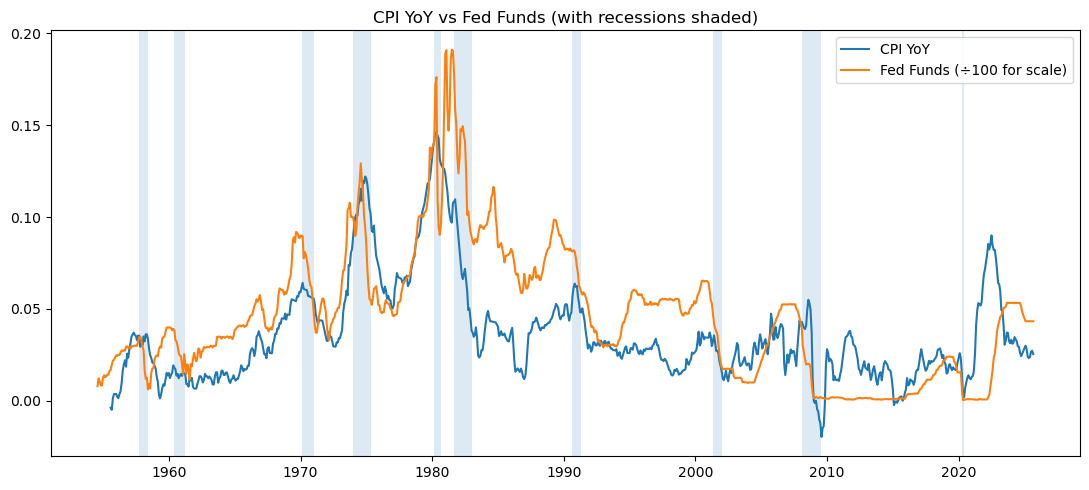

Saved figure: C:\Users\Brazi\OneDrive\Project\gold\plot_cpi_leadlag_sp500.png


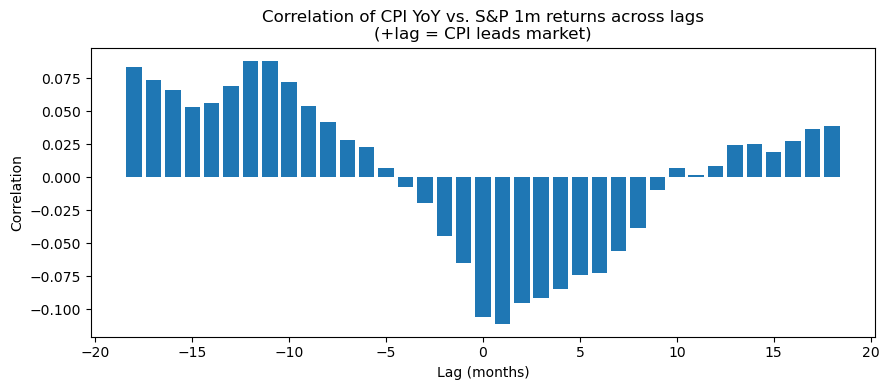

Saved figure: C:\Users\Brazi\OneDrive\Project\gold\plot_stimulus_event_study.png


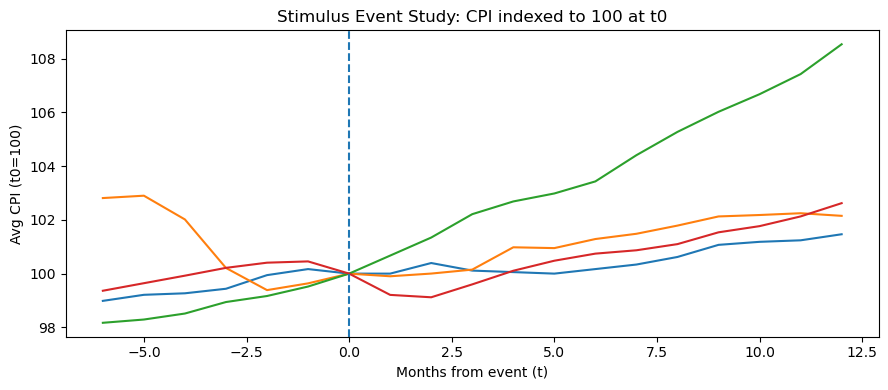


=== Headline Metrics ===
Avg months from hike-cycle start to CPI deceleration: 10.12
Lead/Lag with equities: max |corr|=-0.111 at lag=1 months (CPI leads).
Event study programs: 2001 Tax Rebates, ARRA 2009, American Rescue 21, COVID CARES 2020


In [6]:
# ============================================
# Macro Project: CPI, Fed Funds, Markets, Stimulus
# All-in-one Jupyter script
# ============================================

# ---- Imports
import os, io, json, textwrap, math, datetime as dt
from dataclasses import dataclass
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt

# ---- Config / Output folders
OUT_DIR = r"C:\Users\Brazi\OneDrive\Project"
BRONZE = os.path.join(OUT_DIR, "bronze")
SILVER = os.path.join(OUT_DIR, "silver")
GOLD   = os.path.join(OUT_DIR, "gold")
for d in [OUT_DIR, BRONZE, SILVER, GOLD]:
    os.makedirs(d, exist_ok=True)

# ---- Helpers
def month_end(d):
    d = pd.Timestamp(d)
    return (d + pd.offsets.MonthEnd(0)).normalize()

def to_month_index(s: pd.Series) -> pd.Series:
    return s.map(month_end)

def yoy(series: pd.Series, periods=12) -> pd.Series:
    return series.div(series.shift(periods)) - 1

def pct_change(series: pd.Series, periods=1) -> pd.Series:
    return series.pct_change(periods)

def save(df: pd.DataFrame, base: str):
    """Save both Parquet and CSV."""
    pqt = f"{base}.parquet"
    csv = f"{base}.csv"
    df.to_parquet(pqt, index=True)
    df.to_csv(csv, index=True)
    print(f"Saved: {pqt} and {csv}")

# ---- FRED fetcher
FRED_API_KEY = os.getenv("FRED_API_KEY", "").strip()
FRED_BASE = "https://api.stlouisfed.org/fred/series/observations"

def fetch_fred_series(series_id: str,
                      start="1947-01-01",
                      end=None,
                      frequency="m") -> pd.DataFrame:
    """
    Returns a monthly DataFrame with columns:
      date (Timestamp, month-end), value (float)
    """
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "frequency": frequency
    }
    if start:
        params["observation_start"] = start
    if end:
        params["observation_end"] = end

    r = requests.get(FRED_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json().get("observations", [])
    df = pd.DataFrame(data)
    if df.empty:
        raise ValueError(f"No data from FRED for {series_id}")
    df["date"] = pd.to_datetime(df["date"]).map(month_end)
    # FRED sometimes has "." for missing values
    df["value"] = pd.to_numeric(df["value"].replace(".", np.nan), errors="coerce")
    df = df[["date", "value"]].dropna().sort_values("date").reset_index(drop=True)
    return df

# ---- Yahoo Finance helper (S&P 500)
def fetch_sp500_monthly(start="1950-01-01", end=None) -> pd.DataFrame:
    """
    Pull ^GSPC from Yahoo Finance, monthly.
    Returns columns: date, close, ret_1m
    """
    if end is None:
        end = dt.date.today().isoformat()
    sp = yf.download("^GSPC", start=start, end=end, interval="1mo",
                     auto_adjust=True, progress=False)

    # >>> IMPORTANT: flatten possible MultiIndex columns from yfinance
    if isinstance(sp.columns, pd.MultiIndex):
        # take the first level names (Open/High/Low/Close/Adj Close/Volume)
        sp.columns = sp.columns.get_level_values(0)

    sp = sp.rename_axis("date").reset_index()
    sp["date"] = sp["date"].map(month_end)
    sp = sp[["date", "Close"]].rename(columns={"Close": "close"})
    sp["ret_1m"] = sp["close"].pct_change()
    return sp.dropna().reset_index(drop=True)


# =========================
# 1) BRONZE: pull raw data
# =========================

print("Fetching CPI (CPIAUCSL) …")
bronze_cpi = fetch_fred_series("CPIAUCSL", start="1950-01-01")
save(bronze_cpi, os.path.join(BRONZE, "fred_cpi_CPIAUCSL"))

print("Fetching Fed Funds (FEDFUNDS) …")
bronze_ffr = fetch_fred_series("FEDFUNDS", start="1954-07-01")
save(bronze_ffr, os.path.join(BRONZE, "fred_fedfunds_FEDFUNDS"))

print("Fetching NBER Recession indicator (USREC) …")
bronze_usrec = fetch_fred_series("USREC", start="1950-01-01")
bronze_usrec["value"] = bronze_usrec["value"].astype(int)
save(bronze_usrec, os.path.join(BRONZE, "fred_usrec_USREC"))

print("Fetching S&P 500 monthly (^GSPC) …")
bronze_spx = fetch_sp500_monthly(start="1950-01-01")
save(bronze_spx, os.path.join(BRONZE, "yahoo_sp500_GSPC"))

# ======================================
# 2) SILVER: tidy, typed, aligned monthly
# ======================================

silver_cpi = bronze_cpi.rename(columns={"value": "cpi_index"}).set_index("date")
silver_ffr = bronze_ffr.rename(columns={"value": "ffr"}).set_index("date")
silver_usrec = bronze_usrec.rename(columns={"value": "recession"}).set_index("date")
silver_spx = bronze_spx.set_index("date")

# Make sure all are month-end aligned; join later on full index
# Make sure all are month-end aligned; join later on full index
common_index = pd.date_range(
    start=min(df.index.min() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    end=max(df.index.max() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    freq="ME"  # 'M' deprecated -> use 'ME'
)

silver_cpi = silver_cpi.reindex(common_index).interpolate()
silver_ffr = silver_ffr.reindex(common_index).interpolate()
silver_usrec = silver_usrec.reindex(common_index).ffill().fillna(0).astype(int)  # replace fillna(method="ffill")
silver_spx = silver_spx.reindex(common_index).interpolate()
silver_spx["ret_3m"] = (silver_spx["close"] / silver_spx["close"].shift(3) - 1)

save(silver_cpi.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "cpi_monthly"))
save(silver_ffr.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "fedfunds_monthly"))
save(silver_spx.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "sp500_monthly"))
save(silver_usrec.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "usrec_monthly"))

# ======================================
# 3) GOLD tables & analysis-friendly sets
# ======================================

# ---- GOLD (A): CPI vs Fed Funds (YoY, ΔFFR)
gold_a = pd.concat(
    [
        silver_cpi,
        silver_ffr,
        silver_usrec
    ],
    axis=1
).dropna(subset=["cpi_index", "ffr"])

gold_a["cpi_yoy"] = yoy(gold_a["cpi_index"])
gold_a["dcpi_yoy"] = gold_a["cpi_yoy"].diff()
gold_a["d_ffr"] = gold_a["ffr"].diff()
gold_a = gold_a.join(silver_spx[["close", "ret_1m", "ret_3m"]], how="left")

save(gold_a.reset_index().rename(columns={"index": "date"}), os.path.join(GOLD, "cpi_vs_fedfunds_monthly"))

# ---- Identify rate-hike cycles & lag to CPI deceleration
def tag_hiking_cycles(ffr: pd.Series, min_consecutive=2, rise_threshold=0.0):
    """
    Tags hiking 'cycles': sequences where d_ffr > rise_threshold for >= min_consecutive months.
    Returns a DataFrame with columns: cycle_id (int or NaN), is_hike_month (bool)
    """
    d = ffr.diff()
    up = (d > rise_threshold).astype(int)
    # group consecutive ups
    grp = (up.ne(up.shift()).cumsum()) * up
    sizes = up.groupby(grp).transform("size")
    cycle_id = grp.where((up == 1) & (sizes >= min_consecutive))
    return pd.DataFrame({"cycle_id": cycle_id, "is_hike_month": up.astype(bool)})

hike_tags = tag_hiking_cycles(gold_a["ffr"])
gold_a = gold_a.join(hike_tags)

def months_to_cpi_deceleration(df, window=6):
    """
    For each hiking cycle, compute months from the cycle start to the first sustained
    deceleration in CPI YoY (negative avg dcpi_yoy over a 'window' months).
    """
    results = []
    for cid in sorted(df["cycle_id"].dropna().unique()):
        block = df[df["cycle_id"] == cid].copy()
        start_date = block.index.min()
        # look forward up to 24 months from cycle start
        fwd = df.loc[start_date:].head(36).copy()
        fwd["dcpi_yoy_ma"] = fwd["dcpi_yoy"].rolling(window).mean()
        hit = fwd.index[fwd["dcpi_yoy_ma"] < 0]
        if len(hit) > 0:
            lag = (hit[0].to_period("M") - start_date.to_period("M")).n
            results.append({"cycle_id": int(cid), "start": start_date, "lag_months_to_decel": lag})
    return pd.DataFrame(results)

lags_df = months_to_cpi_deceleration(gold_a)
save(lags_df, os.path.join(GOLD, "headline_metrics_rate_hike_lags"))

print("\nRate-hike effectiveness: avg months to CPI deceleration:")
if not lags_df.empty:
    print(round(lags_df["lag_months_to_decel"].mean(), 2), "months (avg)")
else:
    print("No cycles detected by the simple rule—tweak thresholds if needed.")

# ---- GOLD (B): CPI lead/lag vs market
def cross_corr_at_lags(x: pd.Series, y: pd.Series, lags=range(-12, 13)):
    """
    Returns DataFrame with lag and correlation.
    By convention, positive lag means x LEADS y by 'lag' months (x shifted forward).
    """
    out = []
    for L in lags:
        if L >= 0:
            corr = x.shift(L).corr(y)
        else:
            corr = x.corr(y.shift(-L))
        out.append({"lag": L, "corr": corr})
    return pd.DataFrame(out)

leadlag_df = cross_corr_at_lags(gold_a["cpi_yoy"], gold_a["ret_1m"], lags=range(-18, 19))
save(leadlag_df, os.path.join(GOLD, "cpi_leadlag_sp500_corr"))

# ---- GOLD (C): Stimulus Event Study (CPI indexed to 100 at t0)
# You can edit this list or load from CSV.
stimulus_events = pd.DataFrame([
    ("2001 Tax Rebates",  "2001-07-01", "EGTRRA rebates"),
    ("ARRA 2009",         "2009-02-01", "Post-GFC stimulus"),
    ("COVID CARES 2020",  "2020-03-01", "Initial pandemic stimulus"),
    ("American Rescue 21","2021-03-01", "ARP Act")
], columns=["program","event_date","notes"])
stimulus_events["event_date"] = pd.to_datetime(stimulus_events["event_date"]).map(month_end)

def months_diff(index: pd.DatetimeIndex, ref: pd.Timestamp) -> np.ndarray:
    """Return month difference (index - ref) in whole months."""
    return (index.year - ref.year) * 12 + (index.month - ref.month)

# Build event windows t=-6..+12
cpi_df = silver_cpi.copy()
cpi_df["date"] = cpi_df.index

evt_list = []
for _, row in stimulus_events.iterrows():
    prog, t0, notes = row["program"], row["event_date"], row["notes"]
    # use month-end frequency explicitly
    window = pd.date_range(t0 - pd.offsets.MonthEnd(6), t0 + pd.offsets.MonthEnd(12), freq="ME")
    w = cpi_df.reindex(window)[["cpi_index"]].copy()

    w["program"] = prog
    w["event_date"] = t0
    # robust month offsets
    w["t"] = months_diff(pd.DatetimeIndex(w.index), pd.Timestamp(t0))

    # index CPI to 100 at t0 (guard if t0 missing)
    if (w["t"] == 0).any() and not pd.isna(w.loc[w["t"] == 0, "cpi_index"]).all():
        cpi_t0 = w.loc[w["t"] == 0, "cpi_index"].iloc[0]
        w["cpi_indexed"] = 100 * w["cpi_index"] / cpi_t0
    else:
        w["cpi_indexed"] = np.nan

    evt_list.append(w.reset_index().rename(columns={"index": "date"}))

event_by_event = pd.concat(evt_list, ignore_index=True)
event_by_program = (event_by_event.groupby(["program","t"])
                    .agg(avg_cpi_indexed=("cpi_indexed","mean"))
                    .reset_index())

save(event_by_event,  os.path.join(GOLD, "stimulus_event_study_by_event"))
save(event_by_program, os.path.join(GOLD, "stimulus_event_study_by_program"))


# ======================================
# 4) Quick visuals (now also saved to /gold/)
# ======================================

def savefig_and_show(filename):
    """Helper: save figure to GOLD folder and also display it."""
    path = os.path.join(GOLD, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    print(f"Saved figure: {path}")
    plt.show()

# ---- Plot 1: CPI YoY vs Fed Funds (with recessions shaded)
plt.figure(figsize=(11,5))
plt.plot(gold_a.index, gold_a["cpi_yoy"], label="CPI YoY")
plt.plot(gold_a.index, gold_a["ffr"]/100.0, label="Fed Funds (÷100 for scale)")

# recession shading
rec = gold_a["recession"].fillna(0)
in_rec = (rec.shift(1, fill_value=0) == 0) & (rec == 1)
out_rec = (rec.shift(1, fill_value=0) == 1) & (rec == 0)
starts = list(gold_a.index[in_rec])
ends   = list(gold_a.index[out_rec])
if len(ends) < len(starts):
    ends.append(gold_a.index[-1])
for s, e in zip(starts, ends):
    plt.axvspan(s, e, alpha=0.15)

plt.title("CPI YoY vs Fed Funds (with recessions shaded)")
plt.legend()
savefig_and_show("plot_cpi_vs_fedfunds.png")

# ---- Plot 2: Lead/Lag correlations
plt.figure(figsize=(9,4))
plt.bar(leadlag_df["lag"], leadlag_df["corr"])
plt.title("Correlation of CPI YoY vs. S&P 1m returns across lags\n(+lag = CPI leads market)")
plt.xlabel("Lag (months)")
plt.ylabel("Correlation")
savefig_and_show("plot_cpi_leadlag_sp500.png")

# ---- Plot 3: Stimulus Event Study
plt.figure(figsize=(9,4))
avg = event_by_program.pivot(index="t", columns="program", values="avg_cpi_indexed")
plt.plot(avg.index, avg)
plt.axvline(0, linestyle="--")
plt.title("Stimulus Event Study: CPI indexed to 100 at t0")
plt.xlabel("Months from event (t)")
plt.ylabel("Avg CPI (t0=100)")
savefig_and_show("plot_stimulus_event_study.png")


# ======================================
# 5) Final: print headline metrics
# ======================================

print("\n=== Headline Metrics ===")
if not lags_df.empty:
    print(f"Avg months from hike-cycle start to CPI deceleration: {lags_df['lag_months_to_decel'].mean():.2f}")
else:
    print("No hiking cycles detected by the simple rule.")

best = leadlag_df.iloc[leadlag_df['corr'].abs().argmax()]
print(f"Lead/Lag with equities: max |corr|={best['corr']:.3f} at lag={int(best['lag'])} months "
      f"({'CPI leads' if best['lag']>0 else ('CPI lags' if best['lag']<0 else 'same month')}).")

print("Event study programs:", ", ".join(sorted(stimulus_events['program'].unique())))


Fetching CPI (CPIAUCSL) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_cpi_CPIAUCSL.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_cpi_CPIAUCSL.csv
Fetching Fed Funds (FEDFUNDS) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_fedfunds_FEDFUNDS.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_fedfunds_FEDFUNDS.csv
Fetching NBER Recession indicator (USREC) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_usrec_USREC.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_usrec_USREC.csv
Fetching S&P 500 monthly (^GSPC) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\yahoo_sp500_GSPC.parquet and C:\Users\Brazi\OneDrive\Project\bronze\yahoo_sp500_GSPC.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\cpi_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\cpi_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\fedfunds_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\fedfunds_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\sp5

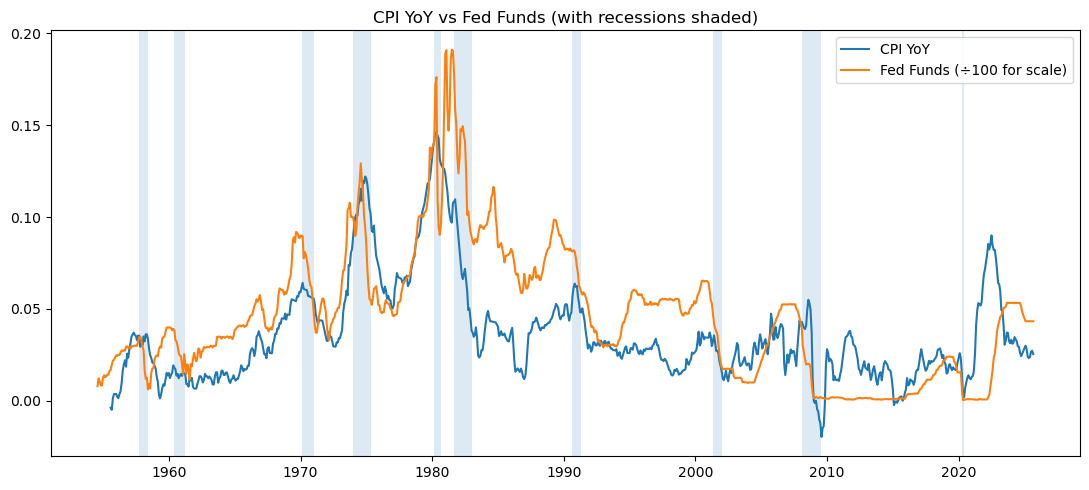

Saved figure: C:\Users\Brazi\OneDrive\Project\Visuals\plot_cpi_leadlag_sp500.png


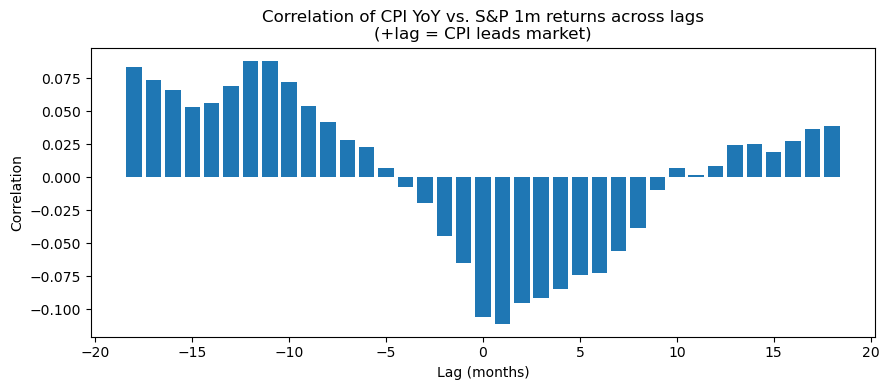

Saved figure: C:\Users\Brazi\OneDrive\Project\Visuals\plot_stimulus_event_study.png


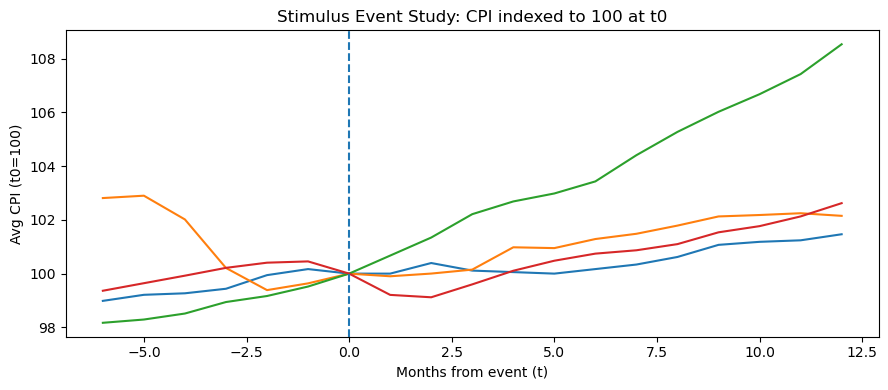


=== Headline Metrics ===
Avg months from hike-cycle start to CPI deceleration: 10.12
Lead/Lag with equities: max |corr|=-0.111 at lag=1 months (CPI leads).
Event study programs: 2001 Tax Rebates, ARRA 2009, American Rescue 21, COVID CARES 2020


In [7]:
# ============================================
# Macro Project: CPI, Fed Funds, Markets, Stimulus
# All-in-one Jupyter script
# ============================================

# ---- Imports
import os, io, json, textwrap, math, datetime as dt
from dataclasses import dataclass
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt

# ---- Config / Output folders
OUT_DIR = r"C:\Users\Brazi\OneDrive\Project"
BRONZE = os.path.join(OUT_DIR, "bronze")
SILVER = os.path.join(OUT_DIR, "silver")
GOLD   = os.path.join(OUT_DIR, "gold")
VISUALS = os.path.join(OUT_DIR, "Visuals")
for d in [OUT_DIR, BRONZE, SILVER, GOLD, VISUALS]:
    os.makedirs(d, exist_ok=True)

# ---- Helpers
def month_end(d):
    d = pd.Timestamp(d)
    return (d + pd.offsets.MonthEnd(0)).normalize()

def to_month_index(s: pd.Series) -> pd.Series:
    return s.map(month_end)

def yoy(series: pd.Series, periods=12) -> pd.Series:
    return series.div(series.shift(periods)) - 1

def pct_change(series: pd.Series, periods=1) -> pd.Series:
    return series.pct_change(periods)

def save(df: pd.DataFrame, base: str):
    """Save both Parquet and CSV."""
    pqt = f"{base}.parquet"
    csv = f"{base}.csv"
    df.to_parquet(pqt, index=True)
    df.to_csv(csv, index=True)
    print(f"Saved: {pqt} and {csv}")

# ---- FRED fetcher
FRED_API_KEY = os.getenv("FRED_API_KEY", "").strip()
FRED_BASE = "https://api.stlouisfed.org/fred/series/observations"

def fetch_fred_series(series_id: str,
                      start="1947-01-01",
                      end=None,
                      frequency="m") -> pd.DataFrame:
    """
    Returns a monthly DataFrame with columns:
      date (Timestamp, month-end), value (float)
    """
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "frequency": frequency
    }
    if start:
        params["observation_start"] = start
    if end:
        params["observation_end"] = end

    r = requests.get(FRED_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json().get("observations", [])
    df = pd.DataFrame(data)
    if df.empty:
        raise ValueError(f"No data from FRED for {series_id}")
    df["date"] = pd.to_datetime(df["date"]).map(month_end)
    # FRED sometimes has "." for missing values
    df["value"] = pd.to_numeric(df["value"].replace(".", np.nan), errors="coerce")
    df = df[["date", "value"]].dropna().sort_values("date").reset_index(drop=True)
    return df

# ---- Yahoo Finance helper (S&P 500)
def fetch_sp500_monthly(start="1950-01-01", end=None) -> pd.DataFrame:
    """
    Pull ^GSPC from Yahoo Finance, monthly.
    Returns columns: date, close, ret_1m
    """
    if end is None:
        end = dt.date.today().isoformat()
    sp = yf.download("^GSPC", start=start, end=end, interval="1mo",
                     auto_adjust=True, progress=False)

    # >>> IMPORTANT: flatten possible MultiIndex columns from yfinance
    if isinstance(sp.columns, pd.MultiIndex):
        # take the first level names (Open/High/Low/Close/Adj Close/Volume)
        sp.columns = sp.columns.get_level_values(0)

    sp = sp.rename_axis("date").reset_index()
    sp["date"] = sp["date"].map(month_end)
    sp = sp[["date", "Close"]].rename(columns={"Close": "close"})
    sp["ret_1m"] = sp["close"].pct_change()
    return sp.dropna().reset_index(drop=True)


# =========================
# 1) BRONZE: pull raw data
# =========================

print("Fetching CPI (CPIAUCSL) …")
bronze_cpi = fetch_fred_series("CPIAUCSL", start="1950-01-01")
save(bronze_cpi, os.path.join(BRONZE, "fred_cpi_CPIAUCSL"))

print("Fetching Fed Funds (FEDFUNDS) …")
bronze_ffr = fetch_fred_series("FEDFUNDS", start="1954-07-01")
save(bronze_ffr, os.path.join(BRONZE, "fred_fedfunds_FEDFUNDS"))

print("Fetching NBER Recession indicator (USREC) …")
bronze_usrec = fetch_fred_series("USREC", start="1950-01-01")
bronze_usrec["value"] = bronze_usrec["value"].astype(int)
save(bronze_usrec, os.path.join(BRONZE, "fred_usrec_USREC"))

print("Fetching S&P 500 monthly (^GSPC) …")
bronze_spx = fetch_sp500_monthly(start="1950-01-01")
save(bronze_spx, os.path.join(BRONZE, "yahoo_sp500_GSPC"))

# ======================================
# 2) SILVER: tidy, typed, aligned monthly
# ======================================

silver_cpi = bronze_cpi.rename(columns={"value": "cpi_index"}).set_index("date")
silver_ffr = bronze_ffr.rename(columns={"value": "ffr"}).set_index("date")
silver_usrec = bronze_usrec.rename(columns={"value": "recession"}).set_index("date")
silver_spx = bronze_spx.set_index("date")

# Make sure all are month-end aligned; join later on full index
# Make sure all are month-end aligned; join later on full index
common_index = pd.date_range(
    start=min(df.index.min() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    end=max(df.index.max() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    freq="ME"  # 'M' deprecated -> use 'ME'
)

silver_cpi = silver_cpi.reindex(common_index).interpolate()
silver_ffr = silver_ffr.reindex(common_index).interpolate()
silver_usrec = silver_usrec.reindex(common_index).ffill().fillna(0).astype(int)  # replace fillna(method="ffill")
silver_spx = silver_spx.reindex(common_index).interpolate()
silver_spx["ret_3m"] = (silver_spx["close"] / silver_spx["close"].shift(3) - 1)

save(silver_cpi.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "cpi_monthly"))
save(silver_ffr.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "fedfunds_monthly"))
save(silver_spx.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "sp500_monthly"))
save(silver_usrec.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "usrec_monthly"))

# ======================================
# 3) GOLD tables & analysis-friendly sets
# ======================================

# ---- GOLD (A): CPI vs Fed Funds (YoY, ΔFFR)
gold_a = pd.concat(
    [
        silver_cpi,
        silver_ffr,
        silver_usrec
    ],
    axis=1
).dropna(subset=["cpi_index", "ffr"])

gold_a["cpi_yoy"] = yoy(gold_a["cpi_index"])
gold_a["dcpi_yoy"] = gold_a["cpi_yoy"].diff()
gold_a["d_ffr"] = gold_a["ffr"].diff()
gold_a = gold_a.join(silver_spx[["close", "ret_1m", "ret_3m"]], how="left")

save(gold_a.reset_index().rename(columns={"index": "date"}), os.path.join(GOLD, "cpi_vs_fedfunds_monthly"))

# ---- Identify rate-hike cycles & lag to CPI deceleration
def tag_hiking_cycles(ffr: pd.Series, min_consecutive=2, rise_threshold=0.0):
    """
    Tags hiking 'cycles': sequences where d_ffr > rise_threshold for >= min_consecutive months.
    Returns a DataFrame with columns: cycle_id (int or NaN), is_hike_month (bool)
    """
    d = ffr.diff()
    up = (d > rise_threshold).astype(int)
    # group consecutive ups
    grp = (up.ne(up.shift()).cumsum()) * up
    sizes = up.groupby(grp).transform("size")
    cycle_id = grp.where((up == 1) & (sizes >= min_consecutive))
    return pd.DataFrame({"cycle_id": cycle_id, "is_hike_month": up.astype(bool)})

hike_tags = tag_hiking_cycles(gold_a["ffr"])
gold_a = gold_a.join(hike_tags)

def months_to_cpi_deceleration(df, window=6):
    """
    For each hiking cycle, compute months from the cycle start to the first sustained
    deceleration in CPI YoY (negative avg dcpi_yoy over a 'window' months).
    """
    results = []
    for cid in sorted(df["cycle_id"].dropna().unique()):
        block = df[df["cycle_id"] == cid].copy()
        start_date = block.index.min()
        # look forward up to 24 months from cycle start
        fwd = df.loc[start_date:].head(36).copy()
        fwd["dcpi_yoy_ma"] = fwd["dcpi_yoy"].rolling(window).mean()
        hit = fwd.index[fwd["dcpi_yoy_ma"] < 0]
        if len(hit) > 0:
            lag = (hit[0].to_period("M") - start_date.to_period("M")).n
            results.append({"cycle_id": int(cid), "start": start_date, "lag_months_to_decel": lag})
    return pd.DataFrame(results)

lags_df = months_to_cpi_deceleration(gold_a)
save(lags_df, os.path.join(GOLD, "headline_metrics_rate_hike_lags"))

print("\nRate-hike effectiveness: avg months to CPI deceleration:")
if not lags_df.empty:
    print(round(lags_df["lag_months_to_decel"].mean(), 2), "months (avg)")
else:
    print("No cycles detected by the simple rule—tweak thresholds if needed.")

# ---- GOLD (B): CPI lead/lag vs market
def cross_corr_at_lags(x: pd.Series, y: pd.Series, lags=range(-12, 13)):
    """
    Returns DataFrame with lag and correlation.
    By convention, positive lag means x LEADS y by 'lag' months (x shifted forward).
    """
    out = []
    for L in lags:
        if L >= 0:
            corr = x.shift(L).corr(y)
        else:
            corr = x.corr(y.shift(-L))
        out.append({"lag": L, "corr": corr})
    return pd.DataFrame(out)

leadlag_df = cross_corr_at_lags(gold_a["cpi_yoy"], gold_a["ret_1m"], lags=range(-18, 19))
save(leadlag_df, os.path.join(GOLD, "cpi_leadlag_sp500_corr"))

# ---- GOLD (C): Stimulus Event Study (CPI indexed to 100 at t0)
# You can edit this list or load from CSV.
stimulus_events = pd.DataFrame([
    ("2001 Tax Rebates",  "2001-07-01", "EGTRRA rebates"),
    ("ARRA 2009",         "2009-02-01", "Post-GFC stimulus"),
    ("COVID CARES 2020",  "2020-03-01", "Initial pandemic stimulus"),
    ("American Rescue 21","2021-03-01", "ARP Act")
], columns=["program","event_date","notes"])
stimulus_events["event_date"] = pd.to_datetime(stimulus_events["event_date"]).map(month_end)

def months_diff(index: pd.DatetimeIndex, ref: pd.Timestamp) -> np.ndarray:
    """Return month difference (index - ref) in whole months."""
    return (index.year - ref.year) * 12 + (index.month - ref.month)

# Build event windows t=-6..+12
cpi_df = silver_cpi.copy()
cpi_df["date"] = cpi_df.index

evt_list = []
for _, row in stimulus_events.iterrows():
    prog, t0, notes = row["program"], row["event_date"], row["notes"]
    # use month-end frequency explicitly
    window = pd.date_range(t0 - pd.offsets.MonthEnd(6), t0 + pd.offsets.MonthEnd(12), freq="ME")
    w = cpi_df.reindex(window)[["cpi_index"]].copy()

    w["program"] = prog
    w["event_date"] = t0
    # robust month offsets
    w["t"] = months_diff(pd.DatetimeIndex(w.index), pd.Timestamp(t0))

    # index CPI to 100 at t0 (guard if t0 missing)
    if (w["t"] == 0).any() and not pd.isna(w.loc[w["t"] == 0, "cpi_index"]).all():
        cpi_t0 = w.loc[w["t"] == 0, "cpi_index"].iloc[0]
        w["cpi_indexed"] = 100 * w["cpi_index"] / cpi_t0
    else:
        w["cpi_indexed"] = np.nan

    evt_list.append(w.reset_index().rename(columns={"index": "date"}))

event_by_event = pd.concat(evt_list, ignore_index=True)
event_by_program = (event_by_event.groupby(["program","t"])
                    .agg(avg_cpi_indexed=("cpi_indexed","mean"))
                    .reset_index())

save(event_by_event,  os.path.join(GOLD, "stimulus_event_study_by_event"))
save(event_by_program, os.path.join(GOLD, "stimulus_event_study_by_program"))


# ======================================
# 4) Quick visuals (now also saved to /gold/)
# ======================================

def savefig_and_show(filename):
    """Helper: save figure to Visuals folder and also display it."""
    path = os.path.join(VISUALS, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    print(f"Saved figure: {path}")
    plt.show()


# ---- Plot 1: CPI YoY vs Fed Funds (with recessions shaded)
plt.figure(figsize=(11,5))
plt.plot(gold_a.index, gold_a["cpi_yoy"], label="CPI YoY")
plt.plot(gold_a.index, gold_a["ffr"]/100.0, label="Fed Funds (÷100 for scale)")

# recession shading
rec = gold_a["recession"].fillna(0)
in_rec = (rec.shift(1, fill_value=0) == 0) & (rec == 1)
out_rec = (rec.shift(1, fill_value=0) == 1) & (rec == 0)
starts = list(gold_a.index[in_rec])
ends   = list(gold_a.index[out_rec])
if len(ends) < len(starts):
    ends.append(gold_a.index[-1])
for s, e in zip(starts, ends):
    plt.axvspan(s, e, alpha=0.15)

plt.title("CPI YoY vs Fed Funds (with recessions shaded)")
plt.legend()
savefig_and_show("plot_cpi_vs_fedfunds.png")

# ---- Plot 2: Lead/Lag correlations
plt.figure(figsize=(9,4))
plt.bar(leadlag_df["lag"], leadlag_df["corr"])
plt.title("Correlation of CPI YoY vs. S&P 1m returns across lags\n(+lag = CPI leads market)")
plt.xlabel("Lag (months)")
plt.ylabel("Correlation")
savefig_and_show("plot_cpi_leadlag_sp500.png")

# ---- Plot 3: Stimulus Event Study
plt.figure(figsize=(9,4))
avg = event_by_program.pivot(index="t", columns="program", values="avg_cpi_indexed")
plt.plot(avg.index, avg)
plt.axvline(0, linestyle="--")
plt.title("Stimulus Event Study: CPI indexed to 100 at t0")
plt.xlabel("Months from event (t)")
plt.ylabel("Avg CPI (t0=100)")
savefig_and_show("plot_stimulus_event_study.png")


# ======================================
# 5) Final: print headline metrics
# ======================================

print("\n=== Headline Metrics ===")
if not lags_df.empty:
    print(f"Avg months from hike-cycle start to CPI deceleration: {lags_df['lag_months_to_decel'].mean():.2f}")
else:
    print("No hiking cycles detected by the simple rule.")

best = leadlag_df.iloc[leadlag_df['corr'].abs().argmax()]
print(f"Lead/Lag with equities: max |corr|={best['corr']:.3f} at lag={int(best['lag'])} months "
      f"({'CPI leads' if best['lag']>0 else ('CPI lags' if best['lag']<0 else 'same month')}).")

print("Event study programs:", ", ".join(sorted(stimulus_events['program'].unique())))


Fetching CPI (CPIAUCSL) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_cpi_CPIAUCSL.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_cpi_CPIAUCSL.csv
Fetching Fed Funds (FEDFUNDS) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_fedfunds_FEDFUNDS.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_fedfunds_FEDFUNDS.csv
Fetching NBER Recession indicator (USREC) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\fred_usrec_USREC.parquet and C:\Users\Brazi\OneDrive\Project\bronze\fred_usrec_USREC.csv
Fetching S&P 500 monthly (^GSPC) …
Saved: C:\Users\Brazi\OneDrive\Project\bronze\yahoo_sp500_GSPC.parquet and C:\Users\Brazi\OneDrive\Project\bronze\yahoo_sp500_GSPC.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\cpi_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\cpi_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\fedfunds_monthly.parquet and C:\Users\Brazi\OneDrive\Project\silver\fedfunds_monthly.csv
Saved: C:\Users\Brazi\OneDrive\Project\silver\sp5

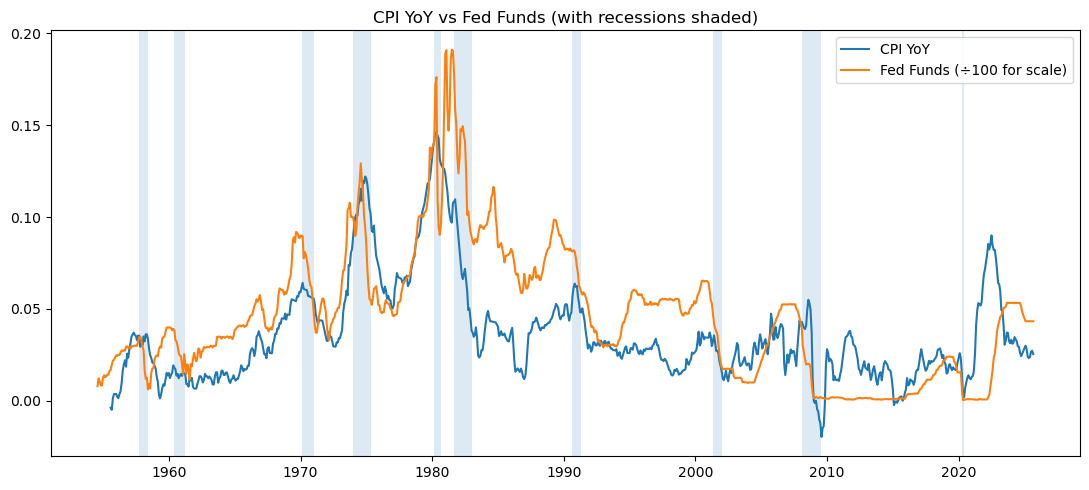

Saved figure: C:\Users\Brazi\OneDrive\Project\Visuals\plot_cpi_leadlag_sp500.png


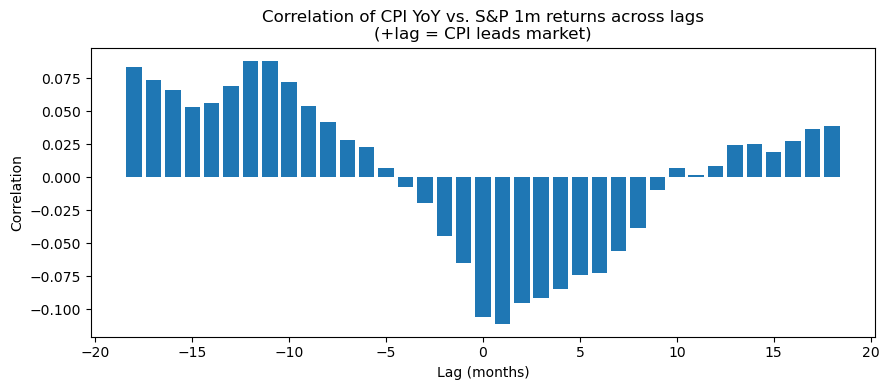

Saved figure: C:\Users\Brazi\OneDrive\Project\Visuals\plot_stimulus_event_study.png


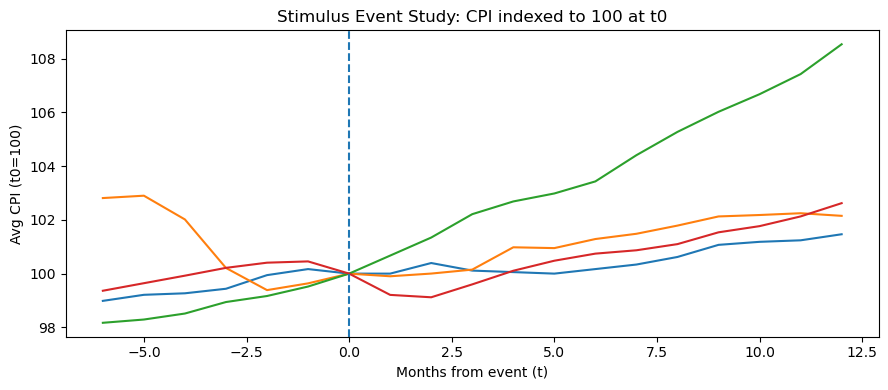


=== Headline Metrics ===
Avg months from hike-cycle start to CPI deceleration: 10.12
Lead/Lag with equities: max |corr|=-0.111 at lag=1 months (CPI leads).
Event study programs: 2001 Tax Rebates, ARRA 2009, American Rescue 21, COVID CARES 2020


In [8]:
# ============================================
# Macro Project: CPI, Fed Funds, Markets, Stimulus
# All-in-one Jupyter script
# ============================================

# ---- Imports
import os, io, json, textwrap, math, datetime as dt
from dataclasses import dataclass
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt

# ---- Config / Output folders
OUT_DIR = r"C:\Users\Brazi\OneDrive\Project"
BRONZE = os.path.join(OUT_DIR, "bronze")
SILVER = os.path.join(OUT_DIR, "silver")
GOLD   = os.path.join(OUT_DIR, "gold")
VISUALS = os.path.join(OUT_DIR, "Visuals")
for d in [OUT_DIR, BRONZE, SILVER, GOLD, VISUALS]:
    os.makedirs(d, exist_ok=True)

# ---- Helpers
def month_end(d):
    d = pd.Timestamp(d)
    return (d + pd.offsets.MonthEnd(0)).normalize()

def to_month_index(s: pd.Series) -> pd.Series:
    return s.map(month_end)

def yoy(series: pd.Series, periods=12) -> pd.Series:
    return series.div(series.shift(periods)) - 1

def pct_change(series: pd.Series, periods=1) -> pd.Series:
    return series.pct_change(periods)

def save(df: pd.DataFrame, base: str):
    """Save both Parquet and CSV."""
    pqt = f"{base}.parquet"
    csv = f"{base}.csv"
    df.to_parquet(pqt, index=True)
    df.to_csv(csv, index=True)
    print(f"Saved: {pqt} and {csv}")

# ---- FRED fetcher
FRED_API_KEY = os.getenv("FRED_API_KEY", "").strip()
FRED_BASE = "https://api.stlouisfed.org/fred/series/observations"

def fetch_fred_series(series_id: str,
                      start="1947-01-01",
                      end=None,
                      frequency="m") -> pd.DataFrame:
    """
    Returns a monthly DataFrame with columns:
      date (Timestamp, month-end), value (float)
    """
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "frequency": frequency
    }
    if start:
        params["observation_start"] = start
    if end:
        params["observation_end"] = end

    r = requests.get(FRED_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json().get("observations", [])
    df = pd.DataFrame(data)
    if df.empty:
        raise ValueError(f"No data from FRED for {series_id}")
    df["date"] = pd.to_datetime(df["date"]).map(month_end)
    # FRED sometimes has "." for missing values
    df["value"] = pd.to_numeric(df["value"].replace(".", np.nan), errors="coerce")
    df = df[["date", "value"]].dropna().sort_values("date").reset_index(drop=True)
    return df

# ---- Yahoo Finance helper (S&P 500)
def fetch_sp500_monthly(start="1950-01-01", end=None) -> pd.DataFrame:
    """
    Pull ^GSPC from Yahoo Finance, monthly.
    Returns columns: date, close, ret_1m
    """
    if end is None:
        end = dt.date.today().isoformat()
    sp = yf.download("^GSPC", start=start, end=end, interval="1mo",
                     auto_adjust=True, progress=False)

    # >>> IMPORTANT: flatten possible MultiIndex columns from yfinance
    if isinstance(sp.columns, pd.MultiIndex):
        # take the first level names (Open/High/Low/Close/Adj Close/Volume)
        sp.columns = sp.columns.get_level_values(0)

    sp = sp.rename_axis("date").reset_index()
    sp["date"] = sp["date"].map(month_end)
    sp = sp[["date", "Close"]].rename(columns={"Close": "close"})
    sp["ret_1m"] = sp["close"].pct_change()
    return sp.dropna().reset_index(drop=True)


# =========================
# 1) BRONZE: pull raw data
# =========================

print("Fetching CPI (CPIAUCSL) …")
bronze_cpi = fetch_fred_series("CPIAUCSL", start="1950-01-01")
save(bronze_cpi, os.path.join(BRONZE, "fred_cpi_CPIAUCSL"))

print("Fetching Fed Funds (FEDFUNDS) …")
bronze_ffr = fetch_fred_series("FEDFUNDS", start="1954-07-01")
save(bronze_ffr, os.path.join(BRONZE, "fred_fedfunds_FEDFUNDS"))

print("Fetching NBER Recession indicator (USREC) …")
bronze_usrec = fetch_fred_series("USREC", start="1950-01-01")
bronze_usrec["value"] = bronze_usrec["value"].astype(int)
save(bronze_usrec, os.path.join(BRONZE, "fred_usrec_USREC"))

print("Fetching S&P 500 monthly (^GSPC) …")
bronze_spx = fetch_sp500_monthly(start="1950-01-01")
save(bronze_spx, os.path.join(BRONZE, "yahoo_sp500_GSPC"))

# ======================================
# 2) SILVER: tidy, typed, aligned monthly
# ======================================

silver_cpi = bronze_cpi.rename(columns={"value": "cpi_index"}).set_index("date")
silver_ffr = bronze_ffr.rename(columns={"value": "ffr"}).set_index("date")
silver_usrec = bronze_usrec.rename(columns={"value": "recession"}).set_index("date")
silver_spx = bronze_spx.set_index("date")

# Make sure all are month-end aligned; join later on full index
# Make sure all are month-end aligned; join later on full index
common_index = pd.date_range(
    start=min(df.index.min() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    end=max(df.index.max() for df in [silver_cpi, silver_ffr, silver_usrec, silver_spx]),
    freq="ME"  # 'M' deprecated -> use 'ME'
)

silver_cpi = silver_cpi.reindex(common_index).interpolate()
silver_ffr = silver_ffr.reindex(common_index).interpolate()
silver_usrec = silver_usrec.reindex(common_index).ffill().fillna(0).astype(int)  # replace fillna(method="ffill")
silver_spx = silver_spx.reindex(common_index).interpolate()
silver_spx["ret_3m"] = (silver_spx["close"] / silver_spx["close"].shift(3) - 1)

save(silver_cpi.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "cpi_monthly"))
save(silver_ffr.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "fedfunds_monthly"))
save(silver_spx.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "sp500_monthly"))
save(silver_usrec.reset_index().rename(columns={"index": "date"}), os.path.join(SILVER, "usrec_monthly"))

# ======================================
# 3) GOLD tables & analysis-friendly sets
# ======================================

# ---- GOLD (A): CPI vs Fed Funds (YoY, ΔFFR)
gold_a = pd.concat(
    [
        silver_cpi,
        silver_ffr,
        silver_usrec
    ],
    axis=1
).dropna(subset=["cpi_index", "ffr"])

gold_a["cpi_yoy"] = yoy(gold_a["cpi_index"])
gold_a["dcpi_yoy"] = gold_a["cpi_yoy"].diff()
gold_a["d_ffr"] = gold_a["ffr"].diff()
gold_a = gold_a.join(silver_spx[["close", "ret_1m", "ret_3m"]], how="left")

save(gold_a.reset_index().rename(columns={"index": "date"}), os.path.join(GOLD, "cpi_vs_fedfunds_monthly"))

# ---- Identify rate-hike cycles & lag to CPI deceleration
def tag_hiking_cycles(ffr: pd.Series, min_consecutive=2, rise_threshold=0.0):
    """
    Tags hiking 'cycles': sequences where d_ffr > rise_threshold for >= min_consecutive months.
    Returns a DataFrame with columns: cycle_id (int or NaN), is_hike_month (bool)
    """
    d = ffr.diff()
    up = (d > rise_threshold).astype(int)
    # group consecutive ups
    grp = (up.ne(up.shift()).cumsum()) * up
    sizes = up.groupby(grp).transform("size")
    cycle_id = grp.where((up == 1) & (sizes >= min_consecutive))
    return pd.DataFrame({"cycle_id": cycle_id, "is_hike_month": up.astype(bool)})

hike_tags = tag_hiking_cycles(gold_a["ffr"])
gold_a = gold_a.join(hike_tags)

def months_to_cpi_deceleration(df, window=6):
    """
    For each hiking cycle, compute months from the cycle start to the first sustained
    deceleration in CPI YoY (negative avg dcpi_yoy over a 'window' months).
    """
    results = []
    for cid in sorted(df["cycle_id"].dropna().unique()):
        block = df[df["cycle_id"] == cid].copy()
        start_date = block.index.min()
        # look forward up to 24 months from cycle start
        fwd = df.loc[start_date:].head(36).copy()
        fwd["dcpi_yoy_ma"] = fwd["dcpi_yoy"].rolling(window).mean()
        hit = fwd.index[fwd["dcpi_yoy_ma"] < 0]
        if len(hit) > 0:
            lag = (hit[0].to_period("M") - start_date.to_period("M")).n
            results.append({"cycle_id": int(cid), "start": start_date, "lag_months_to_decel": lag})
    return pd.DataFrame(results)

lags_df = months_to_cpi_deceleration(gold_a)
save(lags_df, os.path.join(GOLD, "headline_metrics_rate_hike_lags"))

print("\nRate-hike effectiveness: avg months to CPI deceleration:")
if not lags_df.empty:
    print(round(lags_df["lag_months_to_decel"].mean(), 2), "months (avg)")
else:
    print("No cycles detected by the simple rule—tweak thresholds if needed.")

# ---- GOLD (B): CPI lead/lag vs market
def cross_corr_at_lags(x: pd.Series, y: pd.Series, lags=range(-12, 13)):
    """
    Returns DataFrame with lag and correlation.
    By convention, positive lag means x LEADS y by 'lag' months (x shifted forward).
    """
    out = []
    for L in lags:
        if L >= 0:
            corr = x.shift(L).corr(y)
        else:
            corr = x.corr(y.shift(-L))
        out.append({"lag": L, "corr": corr})
    return pd.DataFrame(out)

leadlag_df = cross_corr_at_lags(gold_a["cpi_yoy"], gold_a["ret_1m"], lags=range(-18, 19))
save(leadlag_df, os.path.join(GOLD, "cpi_leadlag_sp500_corr"))

# ---- GOLD (C): Stimulus Event Study (CPI indexed to 100 at t0)
# You can edit this list or load from CSV.
stimulus_events = pd.DataFrame([
    ("2001 Tax Rebates",  "2001-07-01", "EGTRRA rebates"),
    ("ARRA 2009",         "2009-02-01", "Post-GFC stimulus"),
    ("COVID CARES 2020",  "2020-03-01", "Initial pandemic stimulus"),
    ("American Rescue 21","2021-03-01", "ARP Act")
], columns=["program","event_date","notes"])
stimulus_events["event_date"] = pd.to_datetime(stimulus_events["event_date"]).map(month_end)

def months_diff(index: pd.DatetimeIndex, ref: pd.Timestamp) -> np.ndarray:
    """Return month difference (index - ref) in whole months."""
    return (index.year - ref.year) * 12 + (index.month - ref.month)

# Build event windows t=-6..+12
cpi_df = silver_cpi.copy()
cpi_df["date"] = cpi_df.index

evt_list = []
for _, row in stimulus_events.iterrows():
    prog, t0, notes = row["program"], row["event_date"], row["notes"]
    # use month-end frequency explicitly
    window = pd.date_range(t0 - pd.offsets.MonthEnd(6), t0 + pd.offsets.MonthEnd(12), freq="ME")
    w = cpi_df.reindex(window)[["cpi_index"]].copy()

    w["program"] = prog
    w["event_date"] = t0
    # robust month offsets
    w["t"] = months_diff(pd.DatetimeIndex(w.index), pd.Timestamp(t0))

    # index CPI to 100 at t0 (guard if t0 missing)
    if (w["t"] == 0).any() and not pd.isna(w.loc[w["t"] == 0, "cpi_index"]).all():
        cpi_t0 = w.loc[w["t"] == 0, "cpi_index"].iloc[0]
        w["cpi_indexed"] = 100 * w["cpi_index"] / cpi_t0
    else:
        w["cpi_indexed"] = np.nan

    evt_list.append(w.reset_index().rename(columns={"index": "date"}))

event_by_event = pd.concat(evt_list, ignore_index=True)
event_by_program = (event_by_event.groupby(["program","t"])
                    .agg(avg_cpi_indexed=("cpi_indexed","mean"))
                    .reset_index())

save(event_by_event,  os.path.join(GOLD, "stimulus_event_study_by_event"))
save(event_by_program, os.path.join(GOLD, "stimulus_event_study_by_program"))


# ======================================
# 4) Quick visuals (now also saved to /gold/)
# ======================================

def savefig_and_show(filename):
    """Helper: save figure to Visuals folder and also display it (with transparent background)."""
    path = os.path.join(VISUALS, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=150, transparent=True)  # <-- added transparent=True
    print(f"Saved figure: {path}")
    plt.show()


# ---- Plot 1: CPI YoY vs Fed Funds (with recessions shaded)
plt.figure(figsize=(11,5))
plt.plot(gold_a.index, gold_a["cpi_yoy"], label="CPI YoY")
plt.plot(gold_a.index, gold_a["ffr"]/100.0, label="Fed Funds (÷100 for scale)")

# recession shading
rec = gold_a["recession"].fillna(0)
in_rec = (rec.shift(1, fill_value=0) == 0) & (rec == 1)
out_rec = (rec.shift(1, fill_value=0) == 1) & (rec == 0)
starts = list(gold_a.index[in_rec])
ends   = list(gold_a.index[out_rec])
if len(ends) < len(starts):
    ends.append(gold_a.index[-1])
for s, e in zip(starts, ends):
    plt.axvspan(s, e, alpha=0.15)

plt.title("CPI YoY vs Fed Funds (with recessions shaded)")
plt.legend()
savefig_and_show("plot_cpi_vs_fedfunds.png")

# ---- Plot 2: Lead/Lag correlations
plt.figure(figsize=(9,4))
plt.bar(leadlag_df["lag"], leadlag_df["corr"])
plt.title("Correlation of CPI YoY vs. S&P 1m returns across lags\n(+lag = CPI leads market)")
plt.xlabel("Lag (months)")
plt.ylabel("Correlation")
savefig_and_show("plot_cpi_leadlag_sp500.png")

# ---- Plot 3: Stimulus Event Study
plt.figure(figsize=(9,4))
avg = event_by_program.pivot(index="t", columns="program", values="avg_cpi_indexed")
plt.plot(avg.index, avg)
plt.axvline(0, linestyle="--")
plt.title("Stimulus Event Study: CPI indexed to 100 at t0")
plt.xlabel("Months from event (t)")
plt.ylabel("Avg CPI (t0=100)")
savefig_and_show("plot_stimulus_event_study.png")


# ======================================
# 5) Final: print headline metrics
# ======================================

print("\n=== Headline Metrics ===")
if not lags_df.empty:
    print(f"Avg months from hike-cycle start to CPI deceleration: {lags_df['lag_months_to_decel'].mean():.2f}")
else:
    print("No hiking cycles detected by the simple rule.")

best = leadlag_df.iloc[leadlag_df['corr'].abs().argmax()]
print(f"Lead/Lag with equities: max |corr|={best['corr']:.3f} at lag={int(best['lag'])} months "
      f"({'CPI leads' if best['lag']>0 else ('CPI lags' if best['lag']<0 else 'same month')}).")

print("Event study programs:", ", ".join(sorted(stimulus_events['program'].unique())))
